# NeMo SD + ASR - Quartznet VoxConverse DER 35.7%

In [1]:
# """
# You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
# TitaNet: https://arxiv.org/pdf/2110.04410.pdf

# Instructions for setting up Colab are as follows:
# https://colab.research.google.com/drive/1ZoALe4Vy4ekR3eedVwyyt1zF8ZjPZ2JU#scrollTo=sDtW2e8u634q
# 1. Open a new Python 3 notebook.
# 2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
# 3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
# 4. Run this cell to set up dependencies.
# """
# # If you're using Google Colab and not running locally, run this cell.

# ## Install dependencies
# !pip install wget
# !apt-get install sox libsndfile1 ffmpeg
# !pip install unidecode

# # ## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# ## Install TorchAudio
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html
# # !pip install torch==1.11.0 torchaudio==0.11.0 torchvision==0.12.0

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES

3


In [3]:
import os
import glob
import subprocess
import tarfile
import wget
import copy
import pandas as pd
import numpy as np
import IPython
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import spyder
import torchaudio
from collections import Counter
from omegaconf import OmegaConf

from pyannote.metrics.diarization import DiarizationErrorRate
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object
from nemo.collections.asr.models import ClusteringDiarizer
from nemo.collections.asr.parts.utils.decoder_timestamps_utils import ASR_TIMESTAMPS
from nemo.collections.asr.parts.utils.diarization_utils import ASR_DIAR_OFFLINE




/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
[NeMo W 2022-07-25 20:26:53 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [9]:
ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data/voxconverse')
os.makedirs(data_dir, exist_ok=True)
print("ROOT: ", ROOT)
print("Data Directory: ", data_dir)
      
audio_filepath = '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio'
groundtruth_rttm_filepath = os.path.join(data_dir, 'rttms')
print(groundtruth_rttm_filepath)
# has a train,dev,test subdir

if not os.path.exists(audio_filepath):
    print("Please give correct audio location. No ", audio_filepath)
if not os.path.exists(groundtruth_rttm_filepath):
    print("Please give correct rttm groundtruth location. No ", groundtruth_rttm_filepath)

    
test_type = 'test'
groundtruth_rttm_list = []
if test_type == 'test':
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        print(test_path)

!find {audio_filepath} -iname "*.wav" > data/voxconverse/train_all.txt
# !cat {data_dir}/voxconverse/train_all.txt
# DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}


audio_list = []
with open(data_dir+'/train_all.txt') as data:
    audio_list.append(data.read().split())
audio_list = audio_list[0]
audio_list

ROOT:  /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar
Data Directory:  /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/aepyx.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/aggyz.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/aiqwk.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/aorju.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/auzru.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/bgvvt.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/bidnq.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/bjruf.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/bmsyn.rttm
/home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/rttms/test/bpzsc.rttm
/home/DATA/am

['/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aepyx.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aggyz.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aiqwk.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/aorju.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/auzru.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bgvvt.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bidnq.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bjruf.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bmsyn.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bpzsc.wav',
 '/home/DATA/amit_kesari/downloaded-big-datasets/voxconverse_test_wav/audio/bvqnu.wav',
 '/home/DATA/amit_kesari/downloa

In [10]:

def create_input_manifest(
    audio_filepath,
    rttm_filepath,
    offset=0,
    duration=None,
    label='infer',
    text='-',
    num_speakers=None,
    uem_filepath=None,
    manifest_filepath='/data/input_manifest.json' 
):
    # Create a manifest for input with below format. 
    # {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
    # 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
    # if you would like to evaluate with known number of speakers pass the value else None. 
    # If you would like to score the system with known rttms then that should be passed as well, else None
    
    import json
    meta = {
        'audio_filepath': audio_filepath, 
        'offset': 0, 
        'duration':None, 
        'label': 'infer', 
        'text': '-', 
        'num_speakers': num_speakers, 
        'rttm_filepath': rttm_filepath, 
        'uem_filepath' : None
    }
    with open(manifest_filepath,'w') as fp:
        json.dump(meta,fp)
        fp.write('\n')

#     dataframe = pd.DataFrame.from_dict(meta, orient='index')
#     print("Manifest: ", meta)

    
def convert_ami_base():
    # Eg: TS3003a.rttm -> TS3003a.Mix-Headset.rttm
    groundtruth_rttm_list = glob.glob(groundtruth_rttm_filepath + '/test/*.rttm', recursive=True)
    for test_path in groundtruth_rttm_list:
        new_test_path = test_path[:-5]+".Mix-Headset.rttm"
        !mv {test_path} {new_test_path}
        print("new ", new_test_path)
        

def correct_sample_rate(audio_path, show_display=False):
    """
    Corrects the sample rate and channels of audio.
    Display shows audio file but takes time to load
    
    SAMPLE_RATE = 16000
    """
    SAMPLE_RATE = 16000
    waveform, sr = torchaudio.load(audio_path)
    metadata = torchaudio.info(audio_path)

    print(metadata)

    waveform = waveform.mean(dim=0) # if there are multiple channels, average them to single channel
    waveform = waveform.reshape(1, waveform.shape[0])
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        waveform_resampled = resampler(waveform)
        waveform = waveform_resampled

    torchaudio.save(audio_path, waveform, SAMPLE_RATE, bits_per_sample=16, encoding="PCM_S")

    metadata = torchaudio.info(audio_path)
    if show_display:
        # TODO: display_waveform(signal)
        print(f"SR: {SAMPLE_RATE}Hz, {waveform}")
        print("Metadata: ", metadata)
        display(Audio(audio_path,rate=SAMPLE_RATE, autoplay=True))


        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

## Display audio only for visualisation. Add in loop
correct_sample_rate(ROOT+'/data/an4_diarize_test.wav', show_display=False)

AudioMetaData(sample_rate=16000, num_frames=16789675, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [11]:
# single inialisation of manifests and dirs
scripts_dir = os.path.join(ROOT, 'scripts/speaker_tasks')
manifest_filepath = os.path.join(data_dir, 'input_manifest.json')

# config file
MODEL_CONFIG = os.path.join(data_dir,'offline_diarization_with_asr.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization_with_asr.yaml"
    MODEL_CONFIG = wget.download(config_url, data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))


metric = DiarizationErrorRate(collar=0.05)
vox_labels = []

for single_rttm in groundtruth_rttm_list:
    vox_label = single_rttm.split(sep="/")[-1]
    vox_label = vox_label[:-5] # remove .rttm from last
    vox_labels.append(vox_label)
    labels = rttm_to_labels(single_rttm)
    groundtruth = labels_to_pyannote_object(labels)
    num_speakers = Counter([l.split()[-1] for l in labels]).keys().__len__()

    # find the corresponding audio file according to rttm
    single_audio = [audio for audio in audio_list if vox_label in audio][0]
    
    ## -----Visualise data-----
    print("voxconverse_label: ", vox_label)    
    # !cat {single_rttm} # view the sample groundtruth rttm file
    # print("labels: ",vox_label, groundtruth)
    print("num_speakers: ", num_speakers)   
    # print("single_audio: ", single_audio)


    # 1)-----Create input manifest and configs-----
    create_input_manifest(audio_filepath=single_audio, rttm_filepath=single_rttm, num_speakers=num_speakers, manifest_filepath=manifest_filepath)
 
    # Change configurations:
    pretrained_speaker_model='titanet_large'
    config.diarizer.manifest_filepath = manifest_filepath
    config.diarizer.out_dir = data_dir # Directory to store intermediate files and prediction outputs
    config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
    config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
    config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
    config.diarizer.clustering.parameters.oracle_num_speakers=True
    # Using VAD generated from ASR timestamps
    config.diarizer.asr.model_path = 'QuartzNet15x5Base-En'
    config.diarizer.oracle_vad = False # ----> Not using oracle VAD 
    config.diarizer.asr.parameters.asr_based_vad = True
    config.diarizer.asr.parameters.threshold=100 # ASR based VAD threshold: If 100, all silences under 1 sec are ignored.
    config.diarizer.asr.parameters.decoder_delay_in_sec=0.2 # Decoder delay is compensated for 0.2 sec
    
    # 2) ------ASR timestamps-----
    asr_ts_decoder = ASR_TIMESTAMPS(**config.diarizer)
    asr_model = asr_ts_decoder.set_asr_model()
    word_hyp, word_ts_hyp = asr_ts_decoder.run_ASR(asr_model)

    ## debug info
    ## contains the sequence of words.
    # print("Decoded word output dictionary: \n", word_hyp[vox_label])
    ## contains frame level index of the start and the end of each word
    # print("Word-level timestamps dictionary: \n", word_ts_hyp[vox_label])
    
    
    # 3)-----Load model and diarize-----
    asr_diar_offline = ASR_DIAR_OFFLINE(**config.diarizer)
    asr_diar_offline.word_ts_anchor_offset = asr_ts_decoder.word_ts_anchor_offset
    diar_hyp, diar_score = asr_diar_offline.run_diarization(config, word_ts_hyp)
#     print("Diarization hypothesis output: \n", diar_hyp[vox_label])
    print("\n\nDiar score: ", diar_score)
    
#     # 4)-----Accumulate DER-----
    pred_labels = rttm_to_labels(data_dir+'/pred_rttms/'+vox_label+'.rttm')
    hypothesis = labels_to_pyannote_object(pred_labels)
    der = metric(groundtruth, hypothesis)
    print(f"Diarization error rate (DER) = {100 * der:.1f}%\n\n")


    


name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: ???
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshold: 0.25
      sparse_search_volume: 30
      maj_vote_spk_count: false
  asr:
    model_path: ???
    parameters:
      asr_based_vad: false
   

[NeMo W 2022-07-25 20:36:29 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (WER). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-07-25 20:36:42 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


[NeMo W 2022-07-25 20:36:42 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (WER_TS). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:36:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:36:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:36:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:36:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:36:43 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:36:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:36:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:36:44 features:200] PADDING: 16
[NeMo I 2022-07-25 20:36:44 label_models:100] loss is Angular Softmax


[NeMo W 2022-07-25 20:36:44 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                    not been set for this class (TopKClassificationAccuracy). The property determines if `update` by
                    default needs access to the full metric state. If this is not the case, significant speedups can be
                    achieved and we recommend setting this to `False`.
                    We provide an checking function
                    `from torchmetrics.utilities import check_forward_no_full_state`
                    that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                    default for now) or if `full_state_update=False` can be used safely.
                    
      warnings.warn(*args, **kwargs)
    


[NeMo I 2022-07-25 20:36:44 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:36:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:36:44 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:36:44 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:36:44 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:36:44 collections:293] # 294 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]
[NeMo W 2022-07-25 20:36:55 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


[NeMo I 2022-07-25 20:36:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0770	 MISS 0.2172	                 Diarization ER: 0.4687	, Confusion ER:0.1745
[NeMo I 2022-07-25 20:36:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1408e0b20>, {'aepyx': {'speaker_0': 'spk01', 'speaker_1': 'spk03', 'speaker_2': 'spk02', 'speaker_3': 'spk00'}})
Diarization error rate (DER) = 50.9%


voxconverse_label:  aggyz
num_speakers:  13
[NeMo I 2022-07-25 20:36:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:36:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:36:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:36:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:36:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:36:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:36:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:36:58 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:36:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:36:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:36:59 features:200] PADDING: 16
[NeMo I 2022-07-25 20:37:00 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:37:00 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:37:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:00 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:37:00 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:37:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:37:00 collections:293] # 515 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:17<00:00, 17.19s/it]


[NeMo I 2022-07-25 20:37:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0169	 MISS 0.2359	                 Diarization ER: 0.4047	, Confusion ER:0.1519
[NeMo I 2022-07-25 20:37:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05812cbe0>, {'aggyz': {'speaker_0': 'spk03', 'speaker_1': 'spk07', 'speaker_10': 'spk06', 'speaker_11': 'spk01', 'speaker_2': 'spk02', 'speaker_3': 'spk05', 'speaker_5': 'spk12', 'speaker_6': 'spk00', 'speaker_7': 'spk10', 'speaker_8': 'spk04'}})
Diarization error rate (DER) = 43.3%


voxconverse_label:  aiqwk
num_speakers:  8
[NeMo I 2022-07-25 20:37:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:37:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:37:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:37:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:37:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:37:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:37:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:37:23 features:200] PADDING: 16
[NeMo I 2022-07-25 20:37:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:37:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:37:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:37:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:37:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:37:24 collections:293] # 344 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.82s/it]

[NeMo I 2022-07-25 20:37:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0546	 MISS 0.1784	                 Diarization ER: 0.5265	, Confusion ER:0.2936
[NeMo I 2022-07-25 20:37:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0581626a0>, {'aiqwk': {'speaker_0': 'spk07', 'speaker_1': 'spk02', 'speaker_2': 'spk00', 'speaker_4': 'spk06', 'speaker_5': 'spk01', 'speaker_6': 'spk05', 'speaker_7': 'spk04'}})
Diarization error rate (DER) = 56.8%


voxconverse_label:  aorju
num_speakers:  12
[NeMo I 2022-07-25 20:37:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:37:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:37:38 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:37:39 features:200] PADDING: 16
[NeMo I 2022-07-25 20:37:40 save_restore_connector:243] Model EncDecCTCModel was succes

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:37:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:42 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:37:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:37:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:37:42 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:37:43 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:37:43 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:37:43 features:200] PADDING: 16
[NeMo I 2022-07-25 20:37:44 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:37:44 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:37:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:37:44 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:37:44 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:37:44 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:37:44 collections:293] # 2233 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.19s/it]


[NeMo I 2022-07-25 20:38:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0888	 MISS 0.2433	                 Diarization ER: 0.5663	, Confusion ER:0.2342
[NeMo I 2022-07-25 20:38:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140a25f10>, {'aorju': {'speaker_0': 'spk03', 'speaker_1': 'spk02', 'speaker_11': 'spk05', 'speaker_2': 'spk07', 'speaker_4': 'spk00', 'speaker_5': 'spk06', 'speaker_6': 'spk08', 'speaker_7': 'spk01', 'speaker_8': 'spk10'}})
Diarization error rate (DER) = 58.7%


voxconverse_label:  auzru
num_speakers:  8
[NeMo I 2022-07-25 20:38:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-0

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:38:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:38:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:38:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:38:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:38:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:38:14 features:200] PADDING: 16
[NeMo I 2022-07-25 20:38:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:38:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:38:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:38:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:38:15 collections:293] # 889 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.18s/it]


[NeMo I 2022-07-25 20:38:29 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0091	 MISS 0.1936	                 Diarization ER: 0.3229	, Confusion ER:0.1203
[NeMo I 2022-07-25 20:38:29 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140a2e070>, {'auzru': {'speaker_0': 'spk07', 'speaker_1': 'spk00', 'speaker_2': 'spk03', 'speaker_3': 'spk01', 'speaker_5': 'spk06', 'speaker_6': 'spk02', 'speaker_7': 'spk04'}})
Diarization error rate (DER) = 33.8%


voxconverse_label:  bgvvt
num_speakers:  2
[NeMo I 2022-07-25 20:38:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:38:30 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:38:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:34 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:38:34 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:34 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:38:34 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:38:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:38:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:38:35 features:200] PADDING: 16
[NeMo I 2022-07-25 20:38:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:38:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:38:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:38:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:38:36 collections:293] # 1329 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


[NeMo I 2022-07-25 20:38:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1275	 MISS 0.0768	                 Diarization ER: 0.2056	, Confusion ER:0.0013
[NeMo I 2022-07-25 20:38:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05029f100>, {'bgvvt': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 25.4%


voxconverse_label:  bidnq
num_speakers:  11
[NeMo I 2022-07-25 20:38:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:38:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:38:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:56 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:38:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:38:56 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:38:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:38:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:38:57 features:200] PADDING: 16
[NeMo I 2022-07-25 20:38:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:38:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:38:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:38:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:38:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:38:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:38:58 collections:293] # 1186 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


[NeMo I 2022-07-25 20:39:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0087	 MISS 0.0692	                 Diarization ER: 0.4477	, Confusion ER:0.3699
[NeMo I 2022-07-25 20:39:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0504ef1f0>, {'bidnq': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_10': 'spk09', 'speaker_2': 'spk02', 'speaker_3': 'spk07', 'speaker_4': 'spk05', 'speaker_5': 'spk08', 'speaker_6': 'spk04', 'speaker_8': 'spk10', 'speaker_9': 'spk06'}})
Diarization error rate (DER) = 54.3%


voxconverse_label:  bjruf
num_speakers:  2
[NeMo I 2022-07-25 20:39:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-E

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:39:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:39:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:39:17 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:39:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:39:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:39:18 features:200] PADDING: 16
[NeMo I 2022-07-25 20:39:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:39:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:39:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:39:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:39:19 collections:293] # 566 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


[NeMo I 2022-07-25 20:39:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0855	 MISS 0.2185	                 Diarization ER: 0.3433	, Confusion ER:0.0394
[NeMo I 2022-07-25 20:39:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0682310d0>, {'bjruf': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 40.8%


voxconverse_label:  bmsyn
num_speakers:  5
[NeMo I 2022-07-25 20:39:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:39:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:39:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:39:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:39:32 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:39:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:39:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:39:33 features:200] PADDING: 16
[NeMo I 2022-07-25 20:39:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:39:34 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:34 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:39:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:39:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:39:34 collections:293] # 1109 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.11s/it]


[NeMo I 2022-07-25 20:39:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1919	 MISS 0.2271	                 Diarization ER: 0.6694	, Confusion ER:0.2504
[NeMo I 2022-07-25 20:39:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06df031c0>, {'bmsyn': {'speaker_0': 'spk01', 'speaker_1': 'spk04', 'speaker_2': 'spk00', 'speaker_3': 'spk02', 'speaker_4': 'spk03'}})
Diarization error rate (DER) = 74.5%


voxconverse_label:  bpzsc
num_speakers:  7
[NeMo I 2022-07-25 20:39:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:39:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:39:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:39:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:39:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:39:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:39:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:39:55 features:200] PADDING: 16
[NeMo I 2022-07-25 20:39:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:39:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:39:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:39:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:39:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:39:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:39:56 collections:293] # 1238 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.24s/it]


[NeMo I 2022-07-25 20:40:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0337	 MISS 0.0467	                 Diarization ER: 0.6404	, Confusion ER:0.5600
[NeMo I 2022-07-25 20:40:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157db0d60>, {'bpzsc': {'speaker_0': 'spk02', 'speaker_1': 'spk03', 'speaker_2': 'spk04', 'speaker_4': 'spk01', 'speaker_5': 'spk00', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 67.2%


voxconverse_label:  bvqnu
num_speakers:  9
[NeMo I 2022-07-25 20:40:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:40:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:40:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:40:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:40:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:40:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:40:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:40:14 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:40:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:40:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:40:14 features:200] PADDING: 16
[NeMo I 2022-07-25 20:40:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:41:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:41:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:41:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:41:07 collections:293] # 1011 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.69s/it]


[NeMo I 2022-07-25 20:41:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0261	 MISS 0.2215	                 Diarization ER: 0.3546	, Confusion ER:0.1070
[NeMo I 2022-07-25 20:41:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa068239220>, {'bvqnu': {'speaker_0': 'spk00', 'speaker_1': 'spk06', 'speaker_2': 'spk01', 'speaker_5': 'spk08', 'speaker_6': 'spk04', 'speaker_8': 'spk05'}})
Diarization error rate (DER) = 39.5%


voxconverse_label:  bvyvm
num_speakers:  3
[NeMo I 2022-07-25 20:41:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:41:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:41:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:41:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:41:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:41:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:41:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:41:25 features:200] PADDING: 16
[NeMo I 2022-07-25 20:41:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:41:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:26 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:41:26 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:41:26 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:41:26 collections:293] # 233 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]

[NeMo I 2022-07-25 20:41:33 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0437	 MISS 0.2430	                 Diarization ER: 0.3765	, Confusion ER:0.0897
[NeMo I 2022-07-25 20:41:33 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06de48e80>, {'bvyvm': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 41.5%


voxconverse_label:  bxcfq
num_speakers:  2
[NeMo I 2022-07-25 20:41:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:41:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

[NeMo I 2022-07-25 20:41:33 features:200] PADDING: 16
[NeMo I 2022-07-25 20:41:35 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:41:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:41:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:41:36 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:41:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:41:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:41:37 features:200] PADDING: 16
[NeMo I 2022-07-25 20:41:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:41:38 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:41:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:41:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:41:38 collections:293] # 387 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

[NeMo I 2022-07-25 20:41:49 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0000	 MISS 0.2820	                 Diarization ER: 0.3035	, Confusion ER:0.0215
[NeMo I 2022-07-25 20:41:49 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa058192250>, {'bxcfq': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 31.9%


voxconverse_label:  byapz
num_speakers:  15
[NeMo I 2022-07-25 20:41:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:41:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:41:50 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:41:50 features:200] PADDING: 16
[NeMo I 2022-07-25 20:41:52 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:41:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:41:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:41:53 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:41:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:41:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:41:53 features:200] PADDING: 16
[NeMo I 2022-07-25 20:41:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:41:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:41:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:41:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:41:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:41:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:41:54 collections:293] # 545 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.56s/it]


[NeMo I 2022-07-25 20:42:11 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0739	 MISS 0.0712	                 Diarization ER: 0.4977	, Confusion ER:0.3526
[NeMo I 2022-07-25 20:42:11 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0500d2670>, {'byapz': {'speaker_0': 'spk04', 'speaker_1': 'spk00', 'speaker_10': 'spk10', 'speaker_11': 'spk06', 'speaker_14': 'spk08', 'speaker_2': 'spk13', 'speaker_4': 'spk01', 'speaker_5': 'spk12', 'speaker_6': 'spk02', 'speaker_8': 'spk09', 'speaker_9': 'spk07'}})
Diarization error rate (DER) = 53.5%


voxconverse_label:  cadba
num_speakers:  7
[NeMo I 2022-07-25 20:42:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:11 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec81

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:42:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:42:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:42:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:42:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:42:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:42:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:42:16 features:200] PADDING: 16
[NeMo I 2022-07-25 20:42:16 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:42:16 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:42:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:16 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:42:16 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:42:16 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:42:16 collections:293] # 343 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.29s/it]

[NeMo I 2022-07-25 20:42:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0348	 MISS 0.2005	                 Diarization ER: 0.4372	, Confusion ER:0.2019
[NeMo I 2022-07-25 20:42:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa060029310>, {'cadba': {'speaker_0': 'spk06', 'speaker_1': 'spk05', 'speaker_2': 'spk00', 'speaker_3': 'spk04', 'speaker_4': 'spk01', 'speaker_5': 'spk02', 'speaker_6': 'spk03'}})
Diarization error rate (DER) = 50.4%


voxconverse_label:  cawnd
num_speakers:  9
[NeMo I 2022-07-25 20:42:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:42:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:42:27 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:42:28 features:200] PADDING: 16
[NeMo I 2022-07-25 20:42:30 save_restore_connector:243] Model EncDecCTCModel was success

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:42:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:42:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:42:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:42:32 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:42:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:42:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:42:33 features:200] PADDING: 16
[NeMo I 2022-07-25 20:42:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:42:33 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:42:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:33 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:42:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:42:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:42:34 collections:293] # 2122 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.04s/it]


[NeMo I 2022-07-25 20:42:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0241	 MISS 0.2276	                 Diarization ER: 0.3698	, Confusion ER:0.1180
[NeMo I 2022-07-25 20:42:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c7c38b0>, {'cawnd': {'speaker_0': 'spk02', 'speaker_1': 'spk04', 'speaker_2': 'spk08', 'speaker_3': 'spk05', 'speaker_4': 'spk07', 'speaker_5': 'spk00', 'speaker_6': 'spk06', 'speaker_7': 'spk01', 'speaker_8': 'spk03'}})
Diarization error rate (DER) = 38.5%


voxconverse_label:  clfcg
num_speakers:  9
[NeMo I 2022-07-25 20:42:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:42:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:43:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:43:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:43:00 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:43:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:43:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:43:01 features:200] PADDING: 16
[NeMo I 2022-07-25 20:43:02 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:43:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:43:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:43:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:43:02 collections:293] # 536 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.22s/it]


[NeMo I 2022-07-25 20:43:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0753	 MISS 0.2779	                 Diarization ER: 0.5236	, Confusion ER:0.1704
[NeMo I 2022-07-25 20:43:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0503b2e20>, {'clfcg': {'speaker_0': 'spk01', 'speaker_2': 'spk07', 'speaker_3': 'spk02', 'speaker_4': 'spk03', 'speaker_5': 'spk05', 'speaker_6': 'spk00', 'speaker_7': 'spk08', 'speaker_8': 'spk04'}})
Diarization error rate (DER) = 57.9%


voxconverse_label:  cpebh
num_speakers:  1
[NeMo I 2022-07-25 20:43:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:43:19 cloud:62]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:43:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:43:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:43:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:43:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:43:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:43:23 features:200] PADDING: 16
[NeMo I 2022-07-25 20:43:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:43:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:43:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:43:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:43:24 collections:293] # 1356 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.66s/it]


[NeMo I 2022-07-25 20:43:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0151	 MISS 0.2132	                 Diarization ER: 0.2283	, Confusion ER:0.0000
[NeMo I 2022-07-25 20:43:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05062b490>, {'cpebh': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 23.1%


voxconverse_label:  cqfmj
num_speakers:  4
[NeMo I 2022-07-25 20:43:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:43:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-2

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:43:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:43 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:43:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:43:43 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:43:44 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:43:44 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:43:44 features:200] PADDING: 16
[NeMo I 2022-07-25 20:43:44 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:43:45 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:45 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:43:45 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:43:45 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:43:45 collections:293] # 205 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]

[NeMo I 2022-07-25 20:43:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0595	 MISS 0.1927	                 Diarization ER: 0.3310	, Confusion ER:0.0788
[NeMo I 2022-07-25 20:43:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050327be0>, {'cqfmj': {'speaker_0': 'spk01', 'speaker_2': 'spk00', 'speaker_3': 'spk02'}})
Diarization error rate (DER) = 38.3%


voxconverse_label:  crorm
num_speakers:  2
[NeMo I 2022-07-25 20:43:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:43:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

[NeMo I 2022-07-25 20:43:52 features:200] PADDING: 16
[NeMo I 2022-07-25 20:43:53 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:43:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:43:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:43:54 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:43:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:43:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:43:55 features:200] PADDING: 16
[NeMo I 2022-07-25 20:43:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:43:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:43:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:43:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:43:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:43:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:43:56 collections:293] # 1510 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.93s/it]


[NeMo I 2022-07-25 20:44:11 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0196	 MISS 0.1697	                 Diarization ER: 0.2554	, Confusion ER:0.0661
[NeMo I 2022-07-25 20:44:11 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0580559d0>, {'crorm': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 28.0%


voxconverse_label:  crylr
num_speakers:  4
[NeMo I 2022-07-25 20:44:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:44:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:44:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:44:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:44:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:44:17 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:44:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:44:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:44:18 features:200] PADDING: 16
[NeMo I 2022-07-25 20:44:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:44:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:44:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:44:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:44:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:44:19 collections:293] # 308 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.18s/it]

[NeMo I 2022-07-25 20:44:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1555	 MISS 0.2214	                 Diarization ER: 0.4418	, Confusion ER:0.0649
[NeMo I 2022-07-25 20:44:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c8eb310>, {'crylr': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_2': 'spk03'}})
Diarization error rate (DER) = 49.2%


voxconverse_label:  cvofp
num_speakers:  6
[NeMo I 2022-07-25 20:44:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:44:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:44:28 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:44:29 features:200] PADDING: 16
[NeMo I 2022-07-25 20:44:30 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:44:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:44:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:44:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:44:32 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:44:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:44:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:44:33 features:200] PADDING: 16
[NeMo I 2022-07-25 20:44:33 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:44:34 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:44:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:34 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:44:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:44:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:44:34 collections:293] # 2031 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


[NeMo I 2022-07-25 20:44:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0461	 MISS 0.2851	                 Diarization ER: 0.5457	, Confusion ER:0.2144
[NeMo I 2022-07-25 20:44:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0503a5fa0>, {'cvofp': {'speaker_0': 'spk05', 'speaker_1': 'spk02', 'speaker_2': 'spk00', 'speaker_3': 'spk01', 'speaker_4': 'spk03', 'speaker_5': 'spk04'}})
Diarization error rate (DER) = 56.6%


voxconverse_label:  cwbvu
num_speakers:  10
[NeMo I 2022-07-25 20:44:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:44:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:44:59 cloud:62] Re-using file from: /root/.cache/torch/NeM

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:45:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:45:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:45:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:45:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:45:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:45:03 features:200] PADDING: 16
[NeMo I 2022-07-25 20:45:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:45:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:45:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:45:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:45:04 collections:293] # 147 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.26s/it]

[NeMo I 2022-07-25 20:45:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0932	 MISS 0.0494	                 Diarization ER: 0.4925	, Confusion ER:0.3499
[NeMo I 2022-07-25 20:45:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa11cf6e2e0>, {'cwbvu': {'speaker_0': 'spk05', 'speaker_1': 'spk03', 'speaker_3': 'spk06', 'speaker_4': 'spk08', 'speaker_5': 'spk07', 'speaker_6': 'spk09', 'speaker_7': 'spk02', 'speaker_8': 'spk04'}})
Diarization error rate (DER) = 61.2%


voxconverse_label:  dgvwu
num_speakers:  11
[NeMo I 2022-07-25 20:45:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:45:10 cloud:62

[NeMo I 2022-07-25 20:45:10 features:200] PADDING: 16
[NeMo I 2022-07-25 20:45:12 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:45:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:45:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:45:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:45:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:45:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:45:14 features:200] PADDING: 16
[NeMo I 2022-07-25 20:45:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:45:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:45:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:45:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:45:14 collections:293] # 1228 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:30<00:00, 30.58s/it]


[NeMo I 2022-07-25 20:45:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0189	 MISS 0.2041	                 Diarization ER: 0.3564	, Confusion ER:0.1334
[NeMo I 2022-07-25 20:45:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050114130>, {'dgvwu': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_10': 'spk08', 'speaker_2': 'spk02', 'speaker_3': 'spk06', 'speaker_4': 'spk04', 'speaker_5': 'spk09', 'speaker_6': 'spk10', 'speaker_7': 'spk07'}})
Diarization error rate (DER) = 39.8%


voxconverse_label:  diysk
num_speakers:  15
[NeMo I 2022-07-25 20:45:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:45:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:45:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:45:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:45:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:45:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:45:56 features:200] PADDING: 16
[NeMo I 2022-07-25 20:45:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:45:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:45:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:45:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:45:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:45:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:45:57 collections:293] # 1353 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.15s/it]


[NeMo I 2022-07-25 20:46:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0714	 MISS 0.0605	                 Diarization ER: 0.2391	, Confusion ER:0.1072
[NeMo I 2022-07-25 20:46:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa049182160>, {'diysk': {'speaker_0': 'spk04', 'speaker_1': 'spk00', 'speaker_10': 'spk08', 'speaker_13': 'spk02', 'speaker_14': 'spk01', 'speaker_2': 'spk14', 'speaker_3': 'spk10', 'speaker_4': 'spk06', 'speaker_5': 'spk11', 'speaker_6': 'spk03', 'speaker_7': 'spk07', 'speaker_9': 'spk13'}})
Diarization error rate (DER) = 40.1%


voxconverse_label:  dkabn
num_speakers:  7
[NeMo I 2022-07-25 20:46:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:46:16 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066b

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:46:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:46:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:46:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:46:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:46:39 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:46:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:46:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:46:40 features:200] PADDING: 16
[NeMo I 2022-07-25 20:46:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:46:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:46:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:46:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:46:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:46:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:46:41 collections:293] # 1966 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.75s/it]


[NeMo I 2022-07-25 20:46:59 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0956	 MISS 0.2624	                 Diarization ER: 0.5107	, Confusion ER:0.1527
[NeMo I 2022-07-25 20:46:59 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0491823d0>, {'dkabn': {'speaker_0': 'spk00', 'speaker_1': 'spk04', 'speaker_2': 'spk02', 'speaker_3': 'spk05', 'speaker_4': 'spk03', 'speaker_5': 'spk06', 'speaker_6': 'spk01'}})
Diarization error rate (DER) = 54.4%


voxconverse_label:  dlast
num_speakers:  9
[NeMo I 2022-07-25 20:47:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:47:03 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:47:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:10 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:47:11 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:11 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:47:11 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:47:11 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:47:11 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:47:11 features:200] PADDING: 16
[NeMo I 2022-07-25 20:47:12 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:47:12 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:12 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:12 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:47:13 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:47:13 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:47:13 collections:293] # 2308 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.67s/it]


[NeMo I 2022-07-25 20:47:34 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0666	 MISS 0.2400	                 Diarization ER: 0.6370	, Confusion ER:0.3305
[NeMo I 2022-07-25 20:47:34 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0501462e0>, {'dlast': {'speaker_0': 'spk07', 'speaker_1': 'spk03', 'speaker_2': 'spk01', 'speaker_3': 'spk05', 'speaker_5': 'spk04', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 65.8%


voxconverse_label:  dohag
num_speakers:  1
[NeMo I 2022-07-25 20:47:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:47:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:47:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:41 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:47:41 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:41 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:47:41 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:47:42 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:47:42 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:47:42 features:200] PADDING: 16
[NeMo I 2022-07-25 20:47:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:47:43 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:43 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:47:43 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:47:43 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:47:43 collections:293] # 75 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

[NeMo I 2022-07-25 20:47:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0477	 MISS 0.2621	                 Diarization ER: 0.3098	, Confusion ER:0.0000
[NeMo I 2022-07-25 20:47:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06ddb1820>, {'dohag': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 31.8%


voxconverse_label:  duvox
num_speakers:  6
[NeMo I 2022-07-25 20:47:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:47:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-2

[NeMo I 2022-07-25 20:47:45 features:200] PADDING: 16
[NeMo I 2022-07-25 20:47:47 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:47:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:47:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:47:48 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:47:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:47:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:47:49 features:200] PADDING: 16
[NeMo I 2022-07-25 20:47:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:47:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:47:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:47:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:47:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:47:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:47:50 collections:293] # 1138 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.32s/it]


[NeMo I 2022-07-25 20:48:04 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0654	 MISS 0.0735	                 Diarization ER: 0.1513	, Confusion ER:0.0124
[NeMo I 2022-07-25 20:48:04 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1408f9fd0>, {'duvox': {'speaker_0': 'spk05', 'speaker_1': 'spk00', 'speaker_2': 'spk01', 'speaker_3': 'spk03', 'speaker_4': 'spk04'}})
Diarization error rate (DER) = 19.7%


voxconverse_label:  dxbbt
num_speakers:  3
[NeMo I 2022-07-25 20:48:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:48:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:48:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:48:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:48:09 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:48:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:48:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:48:10 features:200] PADDING: 16
[NeMo I 2022-07-25 20:48:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:48:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:48:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:48:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:48:11 collections:293] # 1303 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


[NeMo I 2022-07-25 20:48:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0126	 MISS 0.2436	                 Diarization ER: 0.2973	, Confusion ER:0.0411
[NeMo I 2022-07-25 20:48:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0501afb20>, {'dxbbt': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 32.0%


voxconverse_label:  dxokr
num_speakers:  4
[NeMo I 2022-07-25 20:48:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:48:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:48:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:48:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:48:30 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:48:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:48:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:48:31 features:200] PADDING: 16
[NeMo I 2022-07-25 20:48:32 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:48:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:48:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:48:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:48:32 collections:293] # 361 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.57s/it]

[NeMo I 2022-07-25 20:48:43 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0236	 MISS 0.1920	                 Diarization ER: 0.2901	, Confusion ER:0.0745
[NeMo I 2022-07-25 20:48:43 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05036ae50>, {'dxokr': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_2': 'spk01'}})
Diarization error rate (DER) = 31.0%


voxconverse_label:  dzsef
num_speakers:  3
[NeMo I 2022-07-25 20:48:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:44 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:48:44 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:48:44 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:48:44 features:200] PADDING: 16
[NeMo I 2022-07-25 20:48:46 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:48:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:47 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:48:47 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:47 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:48:47 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:48:48 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:48:48 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:48:48 features:200] PADDING: 16
[NeMo I 2022-07-25 20:48:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:48:49 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:48:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:49 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:48:49 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:48:49 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:48:49 collections:293] # 330 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.66s/it]

[NeMo I 2022-07-25 20:48:59 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0101	 MISS 0.2259	                 Diarization ER: 0.3852	, Confusion ER:0.1492
[NeMo I 2022-07-25 20:48:59 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa069310430>, {'dzsef': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 39.2%


voxconverse_label:  dzxut
num_speakers:  8
[NeMo I 2022-07-25 20:48:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:48:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:48:59 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:48:59 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:49:00 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:01 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:49:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:49:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:49:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:49:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:49:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:49:03 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:49:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:49:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:49:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:49:04 collections:293] # 315 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:07<00:00,  7.93s/it]

[NeMo I 2022-07-25 20:49:13 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1002	 MISS 0.3333	                 Diarization ER: 0.6266	, Confusion ER:0.1932
[NeMo I 2022-07-25 20:49:13 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05001c610>, {'dzxut': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_3': 'spk05', 'speaker_5': 'spk02', 'speaker_6': 'spk07'}})
Diarization error rate (DER) = 67.6%


voxconverse_label:  eauve
num_speakers:  7
[NeMo I 2022-07-25 20:49:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:49:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:49:14 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:49:14 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:16 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:49:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:49:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:49:17 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:49:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:49:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:49:18 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:49:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:49:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:49:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:49:19 collections:293] # 1331 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.37s/it]


[NeMo I 2022-07-25 20:49:34 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0110	 MISS 0.0708	                 Diarization ER: 0.4410	, Confusion ER:0.3592
[NeMo I 2022-07-25 20:49:34 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05048a070>, {'eauve': {'speaker_0': 'spk04', 'speaker_1': 'spk01', 'speaker_2': 'spk00', 'speaker_3': 'spk02', 'speaker_5': 'spk06', 'speaker_6': 'spk05'}})
Diarization error rate (DER) = 51.1%


voxconverse_label:  eazeq
num_speakers:  2
[NeMo I 2022-07-25 20:49:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:49:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:49:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:49:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:49:38 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:49:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:49:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:49:39 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:49:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:49:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:49:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:49:40 collections:293] # 169 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

[NeMo I 2022-07-25 20:49:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0221	 MISS 0.2516	                 Diarization ER: 0.3036	, Confusion ER:0.0299
[NeMo I 2022-07-25 20:49:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05047b880>, {'eazeq': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 37.1%


voxconverse_label:  eddje
num_speakers:  4
[NeMo I 2022-07-25 20:49:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:49:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

[NeMo I 2022-07-25 20:49:47 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:48 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:49:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:49:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:49:49 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:49:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:49:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:49:50 features:200] PADDING: 16
[NeMo I 2022-07-25 20:49:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:49:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:49:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:49:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:49:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:49:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:49:51 collections:293] # 722 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.72s/it]


[NeMo I 2022-07-25 20:50:03 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0359	 MISS 0.2253	                 Diarization ER: 0.3072	, Confusion ER:0.0460
[NeMo I 2022-07-25 20:50:03 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0491504f0>, {'eddje': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_2': 'spk01', 'speaker_3': 'spk02'}})
Diarization error rate (DER) = 40.0%


voxconverse_label:  eguui
num_speakers:  3
[NeMo I 2022-07-25 20:50:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:50:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:50:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:06 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:50:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:06 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:50:06 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:50:07 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:50:07 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:50:07 features:200] PADDING: 16
[NeMo I 2022-07-25 20:50:08 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:50:08 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:08 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:08 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:50:08 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:50:08 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:50:08 collections:293] # 197 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

[NeMo I 2022-07-25 20:50:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1494	 MISS 0.2709	                 Diarization ER: 0.5402	, Confusion ER:0.1199
[NeMo I 2022-07-25 20:50:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050426b80>, {'eguui': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 56.9%


voxconverse_label:  eoyaz
num_speakers:  8
[NeMo I 2022-07-25 20:50:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:50:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

[NeMo I 2022-07-25 20:50:15 features:200] PADDING: 16
[NeMo I 2022-07-25 20:50:16 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:50:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:50:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:50:18 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:50:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:50:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:50:19 features:200] PADDING: 16
[NeMo I 2022-07-25 20:50:19 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:50:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:50:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:50:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:50:20 collections:293] # 391 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.73s/it]

[NeMo I 2022-07-25 20:50:31 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0128	 MISS 0.2211	                 Diarization ER: 0.3413	, Confusion ER:0.1075
[NeMo I 2022-07-25 20:50:31 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048eb3b80>, {'eoyaz': {'speaker_0': 'spk07', 'speaker_1': 'spk03', 'speaker_2': 'spk02', 'speaker_3': 'spk04', 'speaker_5': 'spk01', 'speaker_6': 'spk00', 'speaker_7': 'spk05'}})
Diarization error rate (DER) = 37.8%


voxconverse_label:  epygx
num_speakers:  8
[NeMo I 2022-07-25 20:50:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:50:31 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:50:31 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:50:32 features:200] PADDING: 16
[NeMo I 2022-07-25 20:50:34 save_restore_connector:243] Model EncDecCTCModel was success

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:50:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:50:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:50:36 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:50:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:50:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:50:37 features:200] PADDING: 16
[NeMo I 2022-07-25 20:50:37 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:50:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:50:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:50:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:50:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:50:38 collections:293] # 2044 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.76s/it]


[NeMo I 2022-07-25 20:50:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0780	 MISS 0.2094	                 Diarization ER: 0.4724	, Confusion ER:0.1849
[NeMo I 2022-07-25 20:50:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0500e6640>, {'epygx': {'speaker_0': 'spk04', 'speaker_1': 'spk02', 'speaker_3': 'spk05', 'speaker_5': 'spk06', 'speaker_6': 'spk01', 'speaker_7': 'spk00'}})
Diarization error rate (DER) = 51.4%


voxconverse_label:  eqsta
num_speakers:  15
[NeMo I 2022-07-25 20:50:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:50:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:50:58 cloud:62] Re-using file from: /root/.cache/torch/NeM

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:51:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:51:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:51:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:51:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:51:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:51:03 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:51:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:51:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:51:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:51:04 collections:293] # 1066 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.33s/it]


[NeMo I 2022-07-25 20:51:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0679	 MISS 0.0677	                 Diarization ER: 0.2939	, Confusion ER:0.1583
[NeMo I 2022-07-25 20:51:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06deb60a0>, {'eqsta': {'speaker_1': 'spk02', 'speaker_10': 'spk05', 'speaker_11': 'spk08', 'speaker_12': 'spk12', 'speaker_13': 'spk14', 'speaker_14': 'spk03', 'speaker_3': 'spk07', 'speaker_4': 'spk09', 'speaker_5': 'spk13', 'speaker_6': 'spk06', 'speaker_7': 'spk04', 'speaker_8': 'spk00', 'speaker_9': 'spk01'}})
Diarization error rate (DER) = 43.6%


voxconverse_label:  erslt
num_speakers:  7
[NeMo I 2022-07-25 20:51:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/Qua

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:51:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:51:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:51:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:51:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:51:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:51:24 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:51:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:51:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:51:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:51:25 collections:293] # 244 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.88s/it]

[NeMo I 2022-07-25 20:51:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0842	 MISS 0.3032	                 Diarization ER: 0.5310	, Confusion ER:0.1435
[NeMo I 2022-07-25 20:51:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140849a90>, {'erslt': {'speaker_0': 'spk05', 'speaker_1': 'spk01', 'speaker_2': 'spk02', 'speaker_3': 'spk00', 'speaker_4': 'spk03', 'speaker_5': 'spk04', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 57.3%


voxconverse_label:  eucfa
num_speakers:  4
[NeMo I 2022-07-25 20:51:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:51:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:51:35 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:51:36 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:38 save_restore_connector:243] Model EncDecCTCModel was success

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:51:39 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:39 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:51:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:51:39 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:51:40 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:51:40 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:51:40 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:51:41 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:41 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:41 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:51:41 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:51:41 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:51:41 collections:293] # 153 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:04<00:00,  4.59s/it]

[NeMo I 2022-07-25 20:51:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0321	 MISS 0.1814	                 Diarization ER: 0.3811	, Confusion ER:0.1676
[NeMo I 2022-07-25 20:51:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050376a00>, {'eucfa': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk03', 'speaker_3': 'spk02'}})
Diarization error rate (DER) = 42.8%


voxconverse_label:  euqef
num_speakers:  1
[NeMo I 2022-07-25 20:51:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:51:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e

[NeMo I 2022-07-25 20:51:47 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:49 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:51:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:49 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:51:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:51:49 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:51:50 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:51:50 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:51:50 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:51 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:51:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:51:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:51:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:51:51 collections:293] # 58 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

[NeMo I 2022-07-25 20:51:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.6029	 MISS 0.1962	                 Diarization ER: 0.7992	, Confusion ER:0.0000
[NeMo I 2022-07-25 20:51:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048c2afa0>, {'euqef': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 80.5%


voxconverse_label:  ezxso
num_speakers:  10
[NeMo I 2022-07-25 20:51:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:51:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-

[NeMo I 2022-07-25 20:51:53 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:55 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:51:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:51:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:51:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:51:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:51:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:51:56 features:200] PADDING: 16
[NeMo I 2022-07-25 20:51:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:51:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:51:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:51:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:51:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:51:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:51:57 collections:293] # 537 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


[NeMo I 2022-07-25 20:52:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0374	 MISS 0.2769	                 Diarization ER: 0.4766	, Confusion ER:0.1623
[NeMo I 2022-07-25 20:52:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0490a6190>, {'ezxso': {'speaker_0': 'spk05', 'speaker_1': 'spk06', 'speaker_2': 'spk08', 'speaker_3': 'spk01', 'speaker_4': 'spk00', 'speaker_5': 'spk04', 'speaker_6': 'spk07', 'speaker_7': 'spk03', 'speaker_8': 'spk09'}})
Diarization error rate (DER) = 49.1%


voxconverse_label:  fijfi
num_speakers:  6
[NeMo I 2022-07-25 20:52:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:52:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:52:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:52:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:52:19 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:52:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:52:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:52:19 features:200] PADDING: 16
[NeMo I 2022-07-25 20:52:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:52:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:52:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:52:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:52:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:52:20 collections:293] # 1071 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


[NeMo I 2022-07-25 20:52:34 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0953	 MISS 0.0664	                 Diarization ER: 0.1813	, Confusion ER:0.0196
[NeMo I 2022-07-25 20:52:34 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05020ab50>, {'fijfi': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk04', 'speaker_4': 'spk02', 'speaker_5': 'spk05'}})
Diarization error rate (DER) = 23.7%


voxconverse_label:  fowhl
num_speakers:  6
[NeMo I 2022-07-25 20:52:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:52:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:52:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:52:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:52:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:52:45 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:52:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:52:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:52:46 features:200] PADDING: 16
[NeMo I 2022-07-25 20:52:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:52:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:52:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:52:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:52:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:52:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:52:47 collections:293] # 976 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.96s/it]


[NeMo I 2022-07-25 20:53:00 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0449	 MISS 0.0790	                 Diarization ER: 0.1373	, Confusion ER:0.0134
[NeMo I 2022-07-25 20:53:00 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0503457c0>, {'fowhl': {'speaker_0': 'spk02', 'speaker_1': 'spk00', 'speaker_2': 'spk03', 'speaker_3': 'spk01', 'speaker_4': 'spk05'}})
Diarization error rate (DER) = 20.4%


voxconverse_label:  fpfvy
num_speakers:  11
[NeMo I 2022-07-25 20:53:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:53:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNe

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:53:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:53:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:53:03 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:53:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:53:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:53:04 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:53:05 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:05 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:53:05 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:53:05 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:53:05 collections:293] # 228 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]

[NeMo I 2022-07-25 20:53:12 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0155	 MISS 0.2358	                 Diarization ER: 0.6865	, Confusion ER:0.4352
[NeMo I 2022-07-25 20:53:12 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0501356d0>, {'fpfvy': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_10': 'spk07', 'speaker_2': 'spk06', 'speaker_3': 'spk09', 'speaker_4': 'spk10', 'speaker_6': 'spk02', 'speaker_7': 'spk08', 'speaker_8': 'spk04'}})
Diarization error rate (DER) = 70.7%


voxconverse_label:  fqrnu
num_speakers:  4
[NeMo I 2022-07-25 20:53:12 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-0

[NeMo I 2022-07-25 20:53:13 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:14 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:53:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:53:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:53:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:53:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:53:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:53:16 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:53:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:53:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:53:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:53:17 collections:293] # 294 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.87s/it]

[NeMo I 2022-07-25 20:53:27 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0137	 MISS 0.2292	                 Diarization ER: 0.3623	, Confusion ER:0.1194
[NeMo I 2022-07-25 20:53:27 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06deec490>, {'fqrnu': {'speaker_0': 'spk02', 'speaker_1': 'spk01', 'speaker_2': 'spk00', 'speaker_3': 'spk03'}})
Diarization error rate (DER) = 40.7%


voxconverse_label:  fuzfh
num_speakers:  3
[NeMo I 2022-07-25 20:53:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:53:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:53:28 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:53:28 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:30 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:53:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:53:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:53:30 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:53:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:53:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:53:31 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:31 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:53:31 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:31 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:53:31 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:53:31 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:53:31 collections:293] # 40 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

[NeMo I 2022-07-25 20:53:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0050	 MISS 0.1324	                 Diarization ER: 0.1949	, Confusion ER:0.0575
[NeMo I 2022-07-25 20:53:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa068aff760>, {'fuzfh': {'speaker_0': 'spk00', 'speaker_1': 'spk02'}})
Diarization error rate (DER) = 26.8%


voxconverse_label:  fvhrk
num_speakers:  4
[NeMo I 2022-07-25 20:53:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:53:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

[NeMo I 2022-07-25 20:53:33 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:34 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:53:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:37 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:53:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:53:37 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:53:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:53:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:53:37 features:200] PADDING: 16
[NeMo I 2022-07-25 20:53:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:53:38 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:53:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:53:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:53:39 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:53:39 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:53:39 collections:293] # 2145 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.39s/it]


[NeMo I 2022-07-25 20:53:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0257	 MISS 0.2061	                 Diarization ER: 0.2741	, Confusion ER:0.0424
[NeMo I 2022-07-25 20:53:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157c68d90>, {'fvhrk': {'speaker_0': 'spk02', 'speaker_1': 'spk01', 'speaker_2': 'spk00', 'speaker_3': 'spk03'}})
Diarization error rate (DER) = 29.8%


voxconverse_label:  fxnwf
num_speakers:  3
[NeMo I 2022-07-25 20:54:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:54:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:54:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:54:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:54:05 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:54:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:54:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:54:06 features:200] PADDING: 16
[NeMo I 2022-07-25 20:54:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:54:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:54:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:54:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:54:07 collections:293] # 615 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


[NeMo I 2022-07-25 20:54:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.4178	 MISS 0.2155	                 Diarization ER: 0.7010	, Confusion ER:0.0677
[NeMo I 2022-07-25 20:54:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157cb8d60>, {'fxnwf': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 68.4%


voxconverse_label:  fyqoe
num_speakers:  3
[NeMo I 2022-07-25 20:54:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:54:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:54:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:21 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:54:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:54:21 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:54:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:54:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:54:22 features:200] PADDING: 16
[NeMo I 2022-07-25 20:54:23 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:54:23 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:23 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:54:23 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:54:23 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:54:23 collections:293] # 484 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.93s/it]


[NeMo I 2022-07-25 20:54:37 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1081	 MISS 0.2257	                 Diarization ER: 0.5481	, Confusion ER:0.2144
[NeMo I 2022-07-25 20:54:37 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157b659d0>, {'fyqoe': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 57.4%


voxconverse_label:  fzwtp
num_speakers:  11
[NeMo I 2022-07-25 20:54:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:54:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec81772

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:54:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:54:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:54:40 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:54:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:54:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:54:41 features:200] PADDING: 16
[NeMo I 2022-07-25 20:54:41 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:54:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:43 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:54:43 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:54:43 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:54:43 collections:293] # 436 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.02s/it]


[NeMo I 2022-07-25 20:54:56 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.2474	 MISS 0.1637	                 Diarization ER: 0.6306	, Confusion ER:0.2194
[NeMo I 2022-07-25 20:54:56 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157c1fb50>, {'fzwtp': {'speaker_0': 'spk10', 'speaker_1': 'spk02', 'speaker_10': 'spk09', 'speaker_2': 'spk03', 'speaker_3': 'spk08', 'speaker_4': 'spk00', 'speaker_5': 'spk01', 'speaker_7': 'spk06', 'speaker_8': 'spk04', 'speaker_9': 'spk05'}})
Diarization error rate (DER) = 69.3%


voxconverse_label:  gcfwp
num_speakers:  8
[NeMo I 2022-07-25 20:54:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-E

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:54:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:54:59 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:54:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:54:59 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:54:59 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:55:00 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:55:00 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:55:00 features:200] PADDING: 16
[NeMo I 2022-07-25 20:55:00 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:55:01 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:01 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:55:01 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:55:01 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:55:01 collections:293] # 579 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:15<00:00, 15.03s/it]


[NeMo I 2022-07-25 20:55:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.3125	 MISS 0.1712	                 Diarization ER: 0.7017	, Confusion ER:0.2181
[NeMo I 2022-07-25 20:55:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157c3f7f0>, {'gcfwp': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk04', 'speaker_3': 'spk07', 'speaker_7': 'spk02'}})
Diarization error rate (DER) = 75.3%


voxconverse_label:  gcvrb
num_speakers:  2
[NeMo I 2022-07-25 20:55:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:55:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:55:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:55:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:55:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:55:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:55:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:55:23 features:200] PADDING: 16
[NeMo I 2022-07-25 20:55:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:55:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:55:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:55:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:55:24 collections:293] # 1359 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.57s/it]


[NeMo I 2022-07-25 20:55:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0295	 MISS 0.0542	                 Diarization ER: 0.0900	, Confusion ER:0.0064
[NeMo I 2022-07-25 20:55:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05069d2e0>, {'gcvrb': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 14.8%


voxconverse_label:  gfneh
num_speakers:  7
[NeMo I 2022-07-25 20:55:39 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:39 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:55:39 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:55:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:42 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:55:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:55:42 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:55:43 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:55:43 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:55:43 features:200] PADDING: 16
[NeMo I 2022-07-25 20:55:44 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:55:44 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:44 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:44 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:55:44 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:55:44 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:55:44 collections:293] # 283 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.91s/it]

[NeMo I 2022-07-25 20:55:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0317	 MISS 0.2118	                 Diarization ER: 0.3706	, Confusion ER:0.1271
[NeMo I 2022-07-25 20:55:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140862730>, {'gfneh': {'speaker_0': 'spk03', 'speaker_1': 'spk04', 'speaker_2': 'spk02', 'speaker_3': 'spk00', 'speaker_4': 'spk06', 'speaker_5': 'spk05', 'speaker_6': 'spk01'}})
Diarization error rate (DER) = 43.9%


voxconverse_label:  gkiki
num_speakers:  6
[NeMo I 2022-07-25 20:55:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:55:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 20:55:54 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 20:55:55 features:200] PADDING: 16
[NeMo I 2022-07-25 20:55:56 save_restore_connector:243] Model EncDecCTCModel was success

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:55:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:57 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:55:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:55:57 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:55:58 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:55:58 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:55:58 features:200] PADDING: 16
[NeMo I 2022-07-25 20:55:58 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:55:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:55:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:55:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:55:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:55:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:55:58 collections:293] # 218 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.36s/it]

[NeMo I 2022-07-25 20:56:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0382	 MISS 0.2573	                 Diarization ER: 0.4968	, Confusion ER:0.2012
[NeMo I 2022-07-25 20:56:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa04926b490>, {'gkiki': {'speaker_0': 'spk03', 'speaker_1': 'spk01', 'speaker_2': 'spk05', 'speaker_3': 'spk04', 'speaker_4': 'spk00', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 53.6%


voxconverse_label:  gmmwm
num_speakers:  2
[NeMo I 2022-07-25 20:56:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:56:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo

[NeMo I 2022-07-25 20:56:06 features:200] PADDING: 16
[NeMo I 2022-07-25 20:56:07 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:56:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:56:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:56:09 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:56:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:56:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:56:10 features:200] PADDING: 16
[NeMo I 2022-07-25 20:56:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:56:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:56:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:56:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:56:11 collections:293] # 603 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


[NeMo I 2022-07-25 20:56:15 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0768	 MISS 0.2922	                 Diarization ER: 0.5524	, Confusion ER:0.1835
[NeMo I 2022-07-25 20:56:15 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140849970>, {'gmmwm': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 57.1%


voxconverse_label:  gtjow
num_speakers:  4
[NeMo I 2022-07-25 20:56:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:56:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:56:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:56:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:56:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:56:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:56:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:56:25 features:200] PADDING: 16
[NeMo I 2022-07-25 20:56:26 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:56:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:26 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:56:26 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:56:26 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:56:26 collections:293] # 2067 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.77s/it]


[NeMo I 2022-07-25 20:56:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0339	 MISS 0.2933	                 Diarization ER: 0.6368	, Confusion ER:0.3095
[NeMo I 2022-07-25 20:56:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140872d00>, {'gtjow': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk03', 'speaker_3': 'spk02'}})
Diarization error rate (DER) = 64.3%


voxconverse_label:  gtnjb
num_speakers:  14
[NeMo I 2022-07-25 20:56:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 20:56:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:56:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:56:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:56:53 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:56:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:56:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:56:54 features:200] PADDING: 16
[NeMo I 2022-07-25 20:56:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:56:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:56:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:56:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:56:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:56:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:56:55 collections:293] # 2425 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.14s/it]


[NeMo I 2022-07-25 20:57:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0027	 MISS 0.2709	                 Diarization ER: 0.4471	, Confusion ER:0.1735
[NeMo I 2022-07-25 20:57:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0505da3d0>, {'gtnjb': {'speaker_0': 'spk13', 'speaker_1': 'spk05', 'speaker_12': 'spk01', 'speaker_13': 'spk06', 'speaker_2': 'spk02', 'speaker_3': 'spk11', 'speaker_4': 'spk00', 'speaker_5': 'spk12', 'speaker_6': 'spk08', 'speaker_7': 'spk10', 'speaker_8': 'spk03', 'speaker_9': 'spk09'}})
Diarization error rate (DER) = 46.4%


voxconverse_label:  gukoa
num_speakers:  11
[NeMo I 2022-07-25 20:57:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:57:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066b

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:57:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:57:23 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:57:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:57:23 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:57:23 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:57:24 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:57:24 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:57:24 features:200] PADDING: 16
[NeMo I 2022-07-25 20:57:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:57:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:57:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:57:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:57:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:57:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:57:25 collections:293] # 440 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


[NeMo I 2022-07-25 20:57:38 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0428	 MISS 0.2104	                 Diarization ER: 0.4204	, Confusion ER:0.1671
[NeMo I 2022-07-25 20:57:38 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1409b7190>, {'gukoa': {'speaker_0': 'spk02', 'speaker_1': 'spk04', 'speaker_10': 'spk07', 'speaker_2': 'spk09', 'speaker_3': 'spk00', 'speaker_4': 'spk03', 'speaker_5': 'spk08', 'speaker_7': 'spk01', 'speaker_8': 'spk05', 'speaker_9': 'spk06'}})
Diarization error rate (DER) = 45.1%


voxconverse_label:  guvqf
num_speakers:  11
[NeMo I 2022-07-25 20:57:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:57:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 20:58:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:58:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:58:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:58:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:59:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:59:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:59:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:59:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:59:48 comm

[NeMo W 2022-07-25 20:59:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:59:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:59:49 features:200] PADDING: 16
[NeMo I 2022-07-25 20:59:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:59:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:59:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:59:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:59:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:59:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:59:50 collections:293] # 2291 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.11s/it]


[NeMo I 2022-07-25 21:00:11 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0494	 MISS 0.2400	                 Diarization ER: 0.5190	, Confusion ER:0.2296
[NeMo I 2022-07-25 21:00:11 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa14089ca30>, {'heolf': {'speaker_0': 'spk01', 'speaker_1': 'spk02', 'speaker_10': 'spk00', 'speaker_11': 'spk07', 'speaker_2': 'spk06', 'speaker_3': 'spk10', 'speaker_4': 'spk03', 'speaker_5': 'spk05', 'speaker_6': 'spk08', 'speaker_7': 'spk11', 'speaker_8': 'spk04', 'speaker_9': 'spk09'}})
Diarization error rate (DER) = 54.5%


voxconverse_label:  hhepf
num_speakers:  7
[NeMo I 2022-07-25 21:00:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:00:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:00:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:00:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:00:19 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:00:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:00:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:00:19 features:200] PADDING: 16
[NeMo I 2022-07-25 21:00:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:00:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:00:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:00:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:00:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:00:20 collections:293] # 2088 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.17s/it]


[NeMo I 2022-07-25 21:00:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0344	 MISS 0.2383	                 Diarization ER: 0.5479	, Confusion ER:0.2752
[NeMo I 2022-07-25 21:00:41 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06001b730>, {'hhepf': {'speaker_0': 'spk06', 'speaker_1': 'spk01', 'speaker_2': 'spk00', 'speaker_4': 'spk03', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 57.4%


voxconverse_label:  hqhrb
num_speakers:  6
[NeMo I 2022-07-25 21:00:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:00:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:00:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:50 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:00:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:00:50 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:00:50 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:00:51 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:00:51 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:00:51 features:200] PADDING: 16
[NeMo I 2022-07-25 21:00:51 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:00:51 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:00:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:00:51 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:00:51 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:00:51 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:00:51 collections:293] # 1888 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:45<00:00, 45.47s/it]


[NeMo I 2022-07-25 21:01:45 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1021	 MISS 0.2603	                 Diarization ER: 0.4805	, Confusion ER:0.1181
[NeMo I 2022-07-25 21:01:45 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa060056ac0>, {'hqhrb': {'speaker_0': 'spk00', 'speaker_1': 'spk05', 'speaker_2': 'spk01', 'speaker_3': 'spk04', 'speaker_4': 'spk03', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 50.9%


voxconverse_label:  iabca
num_speakers:  3
[NeMo I 2022-07-25 21:01:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:01:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:01:49 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:01:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:01:51 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:01:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:01:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:01:51 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:01:52 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:01:52 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:01:52 features:200] PADDING: 16
[NeMo I 2022-07-25 21:01:52 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:01:52 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:01:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:01:52 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:01:52 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:01:52 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:01:52 collections:293] # 262 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:06<00:00,  6.81s/it]

[NeMo I 2022-07-25 21:02:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1359	 MISS 0.2096	                 Diarization ER: 0.4007	, Confusion ER:0.0552
[NeMo I 2022-07-25 21:02:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0680b1b50>, {'iabca': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk02'}})
Diarization error rate (DER) = 47.7%


voxconverse_label:  iacod
num_speakers:  6
[NeMo I 2022-07-25 21:02:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:02:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:02:01 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:02:01 features:200] PADDING: 16
[NeMo I 2022-07-25 21:02:03 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:02:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:02:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:02:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:02:05 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:02:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:02:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:02:06 features:200] PADDING: 16
[NeMo I 2022-07-25 21:02:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:02:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:02:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:02:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:02:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:02:07 collections:293] # 1961 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


[NeMo I 2022-07-25 21:02:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1391	 MISS 0.2800	                 Diarization ER: 0.6036	, Confusion ER:0.1845
[NeMo I 2022-07-25 21:02:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05009a3a0>, {'iacod': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_2': 'spk05', 'speaker_3': 'spk01', 'speaker_4': 'spk04', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 62.1%


voxconverse_label:  ibrnm
num_speakers:  12
[NeMo I 2022-07-25 21:02:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:02:29 cloud:62] Re-using file from: /root/.cache/torch/NeM

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:02:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:33 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:02:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:02:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:02:33 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:02:34 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:02:34 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:02:34 features:200] PADDING: 16
[NeMo I 2022-07-25 21:02:34 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:02:35 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:02:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:35 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:02:35 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:02:35 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:02:35 collections:293] # 2065 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.07s/it]


[NeMo I 2022-07-25 21:02:54 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0432	 MISS 0.2337	                 Diarization ER: 0.4280	, Confusion ER:0.1510
[NeMo I 2022-07-25 21:02:54 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048d3aa00>, {'ibrnm': {'speaker_0': 'spk07', 'speaker_1': 'spk00', 'speaker_10': 'spk01', 'speaker_11': 'spk04', 'speaker_2': 'spk02', 'speaker_3': 'spk06', 'speaker_4': 'spk03', 'speaker_5': 'spk08', 'speaker_6': 'spk10', 'speaker_7': 'spk11', 'speaker_8': 'spk09', 'speaker_9': 'spk05'}})
Diarization error rate (DER) = 44.9%


voxconverse_label:  ifwki
num_speakers:  2
[NeMo I 2022-07-25 21:02:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:02:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:03:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:03:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:03:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:03:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:03:00 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:03:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:03:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:03:01 features:200] PADDING: 16
[NeMo I 2022-07-25 21:03:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:03:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:03:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:03:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:03:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:03:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:03:28 collections:293] # 653 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


[NeMo I 2022-07-25 21:03:39 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0327	 MISS 0.2321	                 Diarization ER: 0.3021	, Confusion ER:0.0373
[NeMo I 2022-07-25 21:03:39 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa140867130>, {'ifwki': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 36.3%


voxconverse_label:  iiprr
num_speakers:  7
[NeMo I 2022-07-25 21:03:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:03:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:03:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:03:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:03:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:03:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:03:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:03:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:03:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:03:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:03:56 features:200] PADDING: 16
[NeMo I 2022-07-25 21:03:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:03:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:04:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:04:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:04:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:04:04 collections:293] # 2206 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.72s/it]


[NeMo I 2022-07-25 21:04:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0366	 MISS 0.2340	                 Diarization ER: 0.3865	, Confusion ER:0.1160
[NeMo I 2022-07-25 21:04:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0500ce160>, {'iiprr': {'speaker_0': 'spk02', 'speaker_1': 'spk03', 'speaker_2': 'spk06', 'speaker_3': 'spk04', 'speaker_4': 'spk05', 'speaker_5': 'spk01', 'speaker_6': 'spk00'}})
Diarization error rate (DER) = 42.1%


voxconverse_label:  ikhje
num_speakers:  9
[NeMo I 2022-07-25 21:04:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:04:28 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:04:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:32 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:04:32 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:04:32 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:04:32 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:04:33 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:04:33 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:04:33 features:200] PADDING: 16
[NeMo I 2022-07-25 21:04:34 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:04:34 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:04:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:34 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:04:34 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:04:34 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:04:34 collections:293] # 1055 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.13s/it]


[NeMo I 2022-07-25 21:04:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0441	 MISS 0.0726	                 Diarization ER: 0.3730	, Confusion ER:0.2563
[NeMo I 2022-07-25 21:04:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c7d7250>, {'ikhje': {'speaker_0': 'spk02', 'speaker_1': 'spk06', 'speaker_2': 'spk00', 'speaker_3': 'spk07', 'speaker_4': 'spk04', 'speaker_5': 'spk03', 'speaker_7': 'spk01', 'speaker_8': 'spk05'}})
Diarization error rate (DER) = 42.1%


voxconverse_label:  iowob
num_speakers:  8
[NeMo I 2022-07-25 21:04:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:04:49 cloud:62]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:04:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:04:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:04:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:04:53 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:04:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:04:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:04:54 features:200] PADDING: 16
[NeMo I 2022-07-25 21:04:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:04:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:04:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:04:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:04:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:04:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:04:55 collections:293] # 2102 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


[NeMo I 2022-07-25 21:05:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0448	 MISS 0.2351	                 Diarization ER: 0.3903	, Confusion ER:0.1104
[NeMo I 2022-07-25 21:05:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0501b6d00>, {'iowob': {'speaker_0': 'spk00', 'speaker_1': 'spk02', 'speaker_2': 'spk05', 'speaker_3': 'spk06', 'speaker_5': 'spk04', 'speaker_6': 'spk01', 'speaker_7': 'spk03'}})
Diarization error rate (DER) = 41.1%


voxconverse_label:  isrps
num_speakers:  7
[NeMo I 2022-07-25 21:05:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:05:18 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:05:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:21 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:05:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:05:21 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:05:22 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:05:22 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:05:22 features:200] PADDING: 16
[NeMo I 2022-07-25 21:05:22 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:05:22 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:22 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:05:22 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:05:22 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:05:22 collections:293] # 314 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.29s/it]

[NeMo I 2022-07-25 21:05:33 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0549	 MISS 0.2482	                 Diarization ER: 0.4567	, Confusion ER:0.1536
[NeMo I 2022-07-25 21:05:33 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048c22430>, {'isrps': {'speaker_1': 'spk01', 'speaker_2': 'spk02', 'speaker_3': 'spk03', 'speaker_4': 'spk00', 'speaker_5': 'spk04', 'speaker_6': 'spk05'}})
Diarization error rate (DER) = 51.1%


voxconverse_label:  isxwc
num_speakers:  4
[NeMo I 2022-07-25 21:05:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:05:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:05:33 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:05:34 features:200] PADDING: 16
[NeMo I 2022-07-25 21:05:36 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /r

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:05:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:36 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:05:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:05:36 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:05:37 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:05:37 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:05:37 features:200] PADDING: 16
[NeMo I 2022-07-25 21:05:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:05:38 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:38 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:05:38 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:05:38 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:05:38 collections:293] # 271 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.08s/it]

[NeMo I 2022-07-25 21:05:48 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.2522	 MISS 0.2106	                 Diarization ER: 0.5438	, Confusion ER:0.0809
[NeMo I 2022-07-25 21:05:48 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157c44ee0>, {'isxwc': {'speaker_1': 'spk00', 'speaker_3': 'spk01'}})
Diarization error rate (DER) = 55.7%


voxconverse_label:  jbowg
num_speakers:  13
[NeMo I 2022-07-25 21:05:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:05:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:05:48 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:05:49 features:200] PADDING: 16
[NeMo I 2022-07-25 21:05:51 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:05:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:05:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:05:53 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:05:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:05:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:05:54 features:200] PADDING: 16
[NeMo I 2022-07-25 21:05:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:05:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:05:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:05:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:05:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:05:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:05:55 collections:293] # 2097 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


[NeMo I 2022-07-25 21:06:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0338	 MISS 0.2349	                 Diarization ER: 0.4441	, Confusion ER:0.1754
[NeMo I 2022-07-25 21:06:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa068053b80>, {'jbowg': {'speaker_0': 'spk02', 'speaker_1': 'spk11', 'speaker_10': 'spk00', 'speaker_11': 'spk05', 'speaker_2': 'spk03', 'speaker_3': 'spk08', 'speaker_7': 'spk10', 'speaker_8': 'spk09', 'speaker_9': 'spk07'}})
Diarization error rate (DER) = 46.1%


voxconverse_label:  jdrwl
num_speakers:  7
[NeMo I 2022-07-25 21:06:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:06:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:06:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:06:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:06:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:06:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:06:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:06:23 features:200] PADDING: 16
[NeMo I 2022-07-25 21:06:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:06:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:06:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:06:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:06:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:06:24 collections:293] # 2189 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.91s/it]


[NeMo I 2022-07-25 21:06:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0045	 MISS 0.2484	                 Diarization ER: 0.4689	, Confusion ER:0.2161
[NeMo I 2022-07-25 21:06:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa15821c580>, {'jdrwl': {'speaker_0': 'spk05', 'speaker_1': 'spk03', 'speaker_2': 'spk04', 'speaker_3': 'spk02', 'speaker_5': 'spk01', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 48.3%


voxconverse_label:  jeymh
num_speakers:  18
[NeMo I 2022-07-25 21:06:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:47 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:06:47 cloud:62] Re-using file from: /root/.cache/torch/NeM

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:06:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:06:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:06:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:06:52 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:06:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:06:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:06:53 features:200] PADDING: 16
[NeMo I 2022-07-25 21:06:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:06:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:06:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:06:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:06:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:06:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:06:54 collections:293] # 2326 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


[NeMo I 2022-07-25 21:07:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0431	 MISS 0.2360	                 Diarization ER: 0.5144	, Confusion ER:0.2353
[NeMo I 2022-07-25 21:07:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048ce76a0>, {'jeymh': {'speaker_0': 'spk05', 'speaker_1': 'spk13', 'speaker_11': 'spk01', 'speaker_13': 'spk14', 'speaker_14': 'spk15', 'speaker_15': 'spk03', 'speaker_16': 'spk17', 'speaker_17': 'spk04', 'speaker_2': 'spk08', 'speaker_4': 'spk12', 'speaker_7': 'spk02'}})
Diarization error rate (DER) = 53.2%


voxconverse_label:  jgiyq
num_speakers:  9
[NeMo I 2022-07-25 21:07:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:07:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176e

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:07:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:07:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:07:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:07:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:07:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:07:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:07:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:07:25 features:200] PADDING: 16
[NeMo I 2022-07-25 21:07:26 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:07:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:07:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:07:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:07:30 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:07:30 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:07:30 collections:293] # 2426 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.12s/it]


[NeMo I 2022-07-25 21:07:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0438	 MISS 0.2206	                 Diarization ER: 0.4093	, Confusion ER:0.1448
[NeMo I 2022-07-25 21:07:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa04924ad00>, {'jgiyq': {'speaker_0': 'spk05', 'speaker_1': 'spk00', 'speaker_2': 'spk01', 'speaker_3': 'spk07', 'speaker_4': 'spk02', 'speaker_5': 'spk06', 'speaker_6': 'spk04', 'speaker_7': 'spk08', 'speaker_8': 'spk03'}})
Diarization error rate (DER) = 44.6%


voxconverse_label:  jjkrt
num_speakers:  6
[NeMo I 2022-07-25 21:07:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:07:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:07:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:03 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:08:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:03 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:08:04 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:08:04 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:08:04 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:08:04 features:200] PADDING: 16
[NeMo I 2022-07-25 21:08:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:08:05 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:05 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:08:05 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:08:05 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:08:05 collections:293] # 1181 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.71s/it]


[NeMo I 2022-07-25 21:08:21 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0705	 MISS 0.0803	                 Diarization ER: 0.1644	, Confusion ER:0.0136
[NeMo I 2022-07-25 21:08:21 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157cd8910>, {'jjkrt': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_2': 'spk04', 'speaker_3': 'spk03', 'speaker_4': 'spk02', 'speaker_5': 'spk05'}})
Diarization error rate (DER) = 24.3%


voxconverse_label:  jjvkx
num_speakers:  6
[NeMo I 2022-07-25 21:08:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:08:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:08:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:08:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:08:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:08:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:08:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:08:25 features:200] PADDING: 16
[NeMo I 2022-07-25 21:08:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:08:26 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:26 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:08:26 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:08:26 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:08:26 collections:293] # 397 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

[NeMo I 2022-07-25 21:08:37 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0113	 MISS 0.2642	                 Diarization ER: 0.4536	, Confusion ER:0.1781
[NeMo I 2022-07-25 21:08:37 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1408b3b80>, {'jjvkx': {'speaker_0': 'spk05', 'speaker_1': 'spk03', 'speaker_2': 'spk01', 'speaker_3': 'spk04', 'speaker_4': 'spk00', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 46.9%


voxconverse_label:  jrfaz
num_speakers:  9
[NeMo I 2022-07-25 21:08:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:08:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:08:37 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:08:38 features:200] PADDING: 16
[NeMo I 2022-07-25 21:08:39 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /r

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:08:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:08:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:08:45 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:08:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:08:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:08:46 features:200] PADDING: 16
[NeMo I 2022-07-25 21:08:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:08:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:08:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:08:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:08:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:08:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:08:47 collections:293] # 2151 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


[NeMo I 2022-07-25 21:09:06 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0214	 MISS 0.2517	                 Diarization ER: 0.4405	, Confusion ER:0.1674
[NeMo I 2022-07-25 21:09:06 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c8c96a0>, {'jrfaz': {'speaker_0': 'spk02', 'speaker_1': 'spk06', 'speaker_2': 'spk04', 'speaker_3': 'spk05', 'speaker_5': 'spk03', 'speaker_6': 'spk08', 'speaker_7': 'spk01', 'speaker_8': 'spk00'}})
Diarization error rate (DER) = 47.3%


voxconverse_label:  jsbdo
num_speakers:  7
[NeMo I 2022-07-25 21:09:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:09:10 cloud:62]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:09:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:09:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:09:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:09:14 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:09:14 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:09:14 features:200] PADDING: 16
[NeMo I 2022-07-25 21:09:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:09:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:09:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:09:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:09:15 collections:293] # 984 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.44s/it]


[NeMo I 2022-07-25 21:09:28 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0333	 MISS 0.0675	                 Diarization ER: 0.2996	, Confusion ER:0.1988
[NeMo I 2022-07-25 21:09:28 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa058086280>, {'jsbdo': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_2': 'spk04', 'speaker_3': 'spk02', 'speaker_4': 'spk06', 'speaker_5': 'spk05'}})
Diarization error rate (DER) = 38.2%


voxconverse_label:  jsymf
num_speakers:  9
[NeMo I 2022-07-25 21:09:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:09:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:09:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:33 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:09:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:09:33 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:09:34 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:09:34 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:09:34 features:200] PADDING: 16
[NeMo I 2022-07-25 21:09:35 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:09:35 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:35 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:09:35 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:09:35 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:09:35 collections:293] # 1185 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.38s/it]


[NeMo I 2022-07-25 21:09:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0633	 MISS 0.0822	                 Diarization ER: 0.2628	, Confusion ER:0.1173
[NeMo I 2022-07-25 21:09:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1408bf250>, {'jsymf': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk03', 'speaker_3': 'spk05', 'speaker_5': 'spk04', 'speaker_6': 'spk07', 'speaker_7': 'spk06', 'speaker_8': 'spk08'}})
Diarization error rate (DER) = 31.0%


voxconverse_label:  jttar
num_speakers:  7
[NeMo I 2022-07-25 21:09:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:50 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:09:50 cloud:62]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:09:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:09:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:09:54 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:09:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:09:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:09:55 features:200] PADDING: 16
[NeMo I 2022-07-25 21:09:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:09:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:09:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:09:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:09:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:09:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:09:55 collections:293] # 1031 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.56s/it]


[NeMo I 2022-07-25 21:10:09 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0211	 MISS 0.1458	                 Diarization ER: 0.5416	, Confusion ER:0.3747
[NeMo I 2022-07-25 21:10:09 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c7bc910>, {'jttar': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_3': 'spk04', 'speaker_5': 'spk05', 'speaker_6': 'spk02'}})
Diarization error rate (DER) = 56.3%


voxconverse_label:  jwggf
num_speakers:  5
[NeMo I 2022-07-25 21:10:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:10:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:10:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:14 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:10:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:10:14 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:10:14 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:10:15 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:10:15 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:10:15 features:200] PADDING: 16
[NeMo I 2022-07-25 21:10:15 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:10:15 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:10:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:15 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:10:15 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:10:15 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:10:15 collections:293] # 1944 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


[NeMo I 2022-07-25 21:10:34 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0623	 MISS 0.2261	                 Diarization ER: 0.3674	, Confusion ER:0.0789
[NeMo I 2022-07-25 21:10:34 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa1408e8190>, {'jwggf': {'speaker_0': 'spk04', 'speaker_1': 'spk00', 'speaker_3': 'spk02', 'speaker_4': 'spk01'}})
Diarization error rate (DER) = 39.8%


voxconverse_label:  jxpom
num_speakers:  7
[NeMo I 2022-07-25 21:10:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:10:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:10:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:40 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:10:40 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:10:40 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:10:40 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:10:41 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:10:41 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:10:41 features:200] PADDING: 16
[NeMo I 2022-07-25 21:10:42 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:10:42 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:10:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:42 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:10:42 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:10:42 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:10:42 collections:293] # 727 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.35s/it]


[NeMo I 2022-07-25 21:10:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1139	 MISS 0.1684	                 Diarization ER: 0.4060	, Confusion ER:0.1238
[NeMo I 2022-07-25 21:10:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0490af730>, {'jxpom': {'speaker_1': 'spk01', 'speaker_2': 'spk04', 'speaker_3': 'spk03', 'speaker_4': 'spk06', 'speaker_5': 'spk00', 'speaker_6': 'spk02'}})
Diarization error rate (DER) = 47.8%


voxconverse_label:  jxydp
num_speakers:  1
[NeMo I 2022-07-25 21:10:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:10:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:10:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:11:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:11:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:11:00 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:11:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:11:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:11:01 features:200] PADDING: 16
[NeMo I 2022-07-25 21:11:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:11:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:11:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:11:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:11:02 collections:293] # 171 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

[NeMo I 2022-07-25 21:11:07 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0000	 MISS 0.2287	                 Diarization ER: 0.2287	, Confusion ER:0.0000
[NeMo I 2022-07-25 21:11:07 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa060035070>, {'jxydp': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 23.2%


voxconverse_label:  jzkzt
num_speakers:  11
[NeMo I 2022-07-25 21:11:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:07 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:11:07 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-

[NeMo I 2022-07-25 21:11:08 features:200] PADDING: 16
[NeMo I 2022-07-25 21:11:09 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:11:12 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:12 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:11:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:12 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:11:12 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:11:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:11:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:11:13 features:200] PADDING: 16
[NeMo I 2022-07-25 21:11:13 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:11:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:11:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:11:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:11:14 collections:293] # 1394 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


[NeMo I 2022-07-25 21:11:29 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0628	 MISS 0.0530	                 Diarization ER: 0.4767	, Confusion ER:0.3609
[NeMo I 2022-07-25 21:11:29 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06df538b0>, {'jzkzt': {'speaker_0': 'spk02', 'speaker_1': 'spk00', 'speaker_10': 'spk08', 'speaker_2': 'spk01', 'speaker_3': 'spk04', 'speaker_4': 'spk06', 'speaker_6': 'spk07', 'speaker_7': 'spk03', 'speaker_8': 'spk05'}})
Diarization error rate (DER) = 57.6%


voxconverse_label:  kajfh
num_speakers:  15
[NeMo I 2022-07-25 21:11:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:11:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:11:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:11:35 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:11:35 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:11:35 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:11:35 features:200] PADDING: 16
[NeMo I 2022-07-25 21:11:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:11:36 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:36 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:11:36 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:11:36 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:11:36 collections:293] # 1484 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.66s/it]


[NeMo I 2022-07-25 21:11:53 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1639	 MISS 0.1935	                 Diarization ER: 0.6266	, Confusion ER:0.2693
[NeMo I 2022-07-25 21:11:53 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048a60160>, {'kajfh': {'speaker_0': 'spk14', 'speaker_1': 'spk01', 'speaker_10': 'spk10', 'speaker_11': 'spk06', 'speaker_12': 'spk04', 'speaker_14': 'spk00', 'speaker_2': 'spk07', 'speaker_3': 'spk09', 'speaker_4': 'spk05', 'speaker_5': 'spk03', 'speaker_8': 'spk02'}})
Diarization error rate (DER) = 65.3%


voxconverse_label:  kgjaa
num_speakers:  10
[NeMo I 2022-07-25 21:11:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:11:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:11:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:11:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:11:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:11:58 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:11:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:11:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:11:59 features:200] PADDING: 16
[NeMo I 2022-07-25 21:12:00 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:12:00 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:12:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:00 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:12:00 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:12:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:12:00 collections:293] # 2170 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.65s/it]


[NeMo I 2022-07-25 21:12:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0462	 MISS 0.2369	                 Diarization ER: 0.4536	, Confusion ER:0.1705
[NeMo I 2022-07-25 21:12:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050303ac0>, {'kgjaa': {'speaker_0': 'spk06', 'speaker_1': 'spk08', 'speaker_2': 'spk04', 'speaker_4': 'spk07', 'speaker_6': 'spk00', 'speaker_7': 'spk09', 'speaker_8': 'spk02', 'speaker_9': 'spk01'}})
Diarization error rate (DER) = 47.5%


voxconverse_label:  kmjvh
num_speakers:  8
[NeMo I 2022-07-25 21:12:23 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:23 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:12:23 cloud:62]

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:12:26 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:26 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:12:26 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:12:26 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:12:26 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:12:27 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:12:27 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:12:27 features:200] PADDING: 16
[NeMo I 2022-07-25 21:12:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:12:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:12:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:12:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:12:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:12:28 collections:293] # 795 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.20s/it]


[NeMo I 2022-07-25 21:12:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0863	 MISS 0.2183	                 Diarization ER: 0.5132	, Confusion ER:0.2086
[NeMo I 2022-07-25 21:12:41 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048ed11c0>, {'kmjvh': {'speaker_0': 'spk04', 'speaker_1': 'spk05', 'speaker_2': 'spk00', 'speaker_3': 'spk06', 'speaker_4': 'spk01', 'speaker_5': 'spk02', 'speaker_6': 'spk07'}})
Diarization error rate (DER) = 57.6%


voxconverse_label:  kmunk
num_speakers:  2
[NeMo I 2022-07-25 21:12:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:12:43 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:12:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:12:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:12:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:12:46 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:12:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:12:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:12:46 features:200] PADDING: 16
[NeMo I 2022-07-25 21:12:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:12:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:12:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:12:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:12:47 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:12:47 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:12:47 collections:293] # 788 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.09s/it]


[NeMo I 2022-07-25 21:13:02 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0337	 MISS 0.2821	                 Diarization ER: 0.3443	, Confusion ER:0.0284
[NeMo I 2022-07-25 21:13:02 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0501bc160>, {'kmunk': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 37.2%


voxconverse_label:  kpjud
num_speakers:  9
[NeMo I 2022-07-25 21:13:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:13:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:13:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:04 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:13:04 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:04 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:13:04 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:13:05 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:13:05 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:13:05 features:200] PADDING: 16
[NeMo I 2022-07-25 21:13:05 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:13:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:13:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:13:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:13:06 collections:293] # 261 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

[NeMo I 2022-07-25 21:13:11 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0073	 MISS 0.2209	                 Diarization ER: 0.4517	, Confusion ER:0.2236
[NeMo I 2022-07-25 21:13:11 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0600a8580>, {'kpjud': {'speaker_0': 'spk05', 'speaker_1': 'spk00', 'speaker_2': 'spk04', 'speaker_5': 'spk01', 'speaker_6': 'spk03', 'speaker_7': 'spk06', 'speaker_8': 'spk02'}})
Diarization error rate (DER) = 51.3%


voxconverse_label:  ktvto
num_speakers:  9
[NeMo I 2022-07-25 21:13:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:11 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:13:11 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:13:11 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:13:12 features:200] PADDING: 16
[NeMo I 2022-07-25 21:13:14 save_restore_connector:243] Model EncDecCTCModel was success

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:13:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:15 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:13:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:13:15 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:13:16 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:13:16 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:13:16 features:200] PADDING: 16
[NeMo I 2022-07-25 21:13:17 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:13:17 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:17 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:13:17 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:13:17 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:13:17 collections:293] # 921 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.60s/it]


[NeMo I 2022-07-25 21:13:30 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0465	 MISS 0.0746	                 Diarization ER: 0.3960	, Confusion ER:0.2749
[NeMo I 2022-07-25 21:13:30 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048d24610>, {'ktvto': {'speaker_0': 'spk04', 'speaker_1': 'spk00', 'speaker_2': 'spk06', 'speaker_3': 'spk03', 'speaker_4': 'spk08', 'speaker_6': 'spk05', 'speaker_8': 'spk01'}})
Diarization error rate (DER) = 45.9%


voxconverse_label:  kvkje
num_speakers:  8
[NeMo I 2022-07-25 21:13:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:31 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:13:31 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:13:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:35 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:13:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:13:35 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:13:36 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:13:36 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:13:36 features:200] PADDING: 16
[NeMo I 2022-07-25 21:13:36 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:13:37 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:13:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:37 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:13:37 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:13:37 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:13:37 collections:293] # 1750 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


[NeMo I 2022-07-25 21:13:55 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0752	 MISS 0.2649	                 Diarization ER: 0.5415	, Confusion ER:0.2014
[NeMo I 2022-07-25 21:13:55 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050801ee0>, {'kvkje': {'speaker_0': 'spk06', 'speaker_1': 'spk05', 'speaker_2': 'spk01', 'speaker_3': 'spk04', 'speaker_5': 'spk00', 'speaker_6': 'spk03', 'speaker_7': 'spk02'}})
Diarization error rate (DER) = 58.3%


voxconverse_label:  kzmyi
num_speakers:  8
[NeMo I 2022-07-25 21:13:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:13:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:13:58 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:14:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:14:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:14:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:14:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:14:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:14:03 features:200] PADDING: 16
[NeMo I 2022-07-25 21:14:03 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:14:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:14:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:14:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:14:04 collections:293] # 1462 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.50s/it]


[NeMo I 2022-07-25 21:14:20 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1139	 MISS 0.2700	                 Diarization ER: 0.6911	, Confusion ER:0.3071
[NeMo I 2022-07-25 21:14:20 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157ef0520>, {'kzmyi': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_2': 'spk07', 'speaker_5': 'spk02', 'speaker_6': 'spk06', 'speaker_7': 'spk03'}})
Diarization error rate (DER) = 71.0%


voxconverse_label:  laoyl
num_speakers:  2
[NeMo I 2022-07-25 21:14:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:14:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:14:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:25 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:14:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:14:25 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:14:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:14:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:14:26 features:200] PADDING: 16
[NeMo I 2022-07-25 21:14:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:14:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:14:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:14:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:14:27 collections:293] # 505 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


[NeMo I 2022-07-25 21:14:42 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0331	 MISS 0.2403	                 Diarization ER: 0.2912	, Confusion ER:0.0178
[NeMo I 2022-07-25 21:14:42 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06ddd6dc0>, {'laoyl': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 33.1%


voxconverse_label:  lbfnx
num_speakers:  15
[NeMo I 2022-07-25 21:14:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:14:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:14:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:14:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:14:46 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:14:47 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:14:47 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:14:47 features:200] PADDING: 16
[NeMo I 2022-07-25 21:14:48 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:14:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:14:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:14:48 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:14:48 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:14:48 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:14:48 collections:293] # 2235 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.82s/it]


[NeMo I 2022-07-25 21:15:08 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0533	 MISS 0.2312	                 Diarization ER: 0.5204	, Confusion ER:0.2359
[NeMo I 2022-07-25 21:15:08 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06810c970>, {'lbfnx': {'speaker_0': 'spk04', 'speaker_1': 'spk12', 'speaker_10': 'spk09', 'speaker_12': 'spk01', 'speaker_13': 'spk00', 'speaker_14': 'spk07', 'speaker_2': 'spk05', 'speaker_3': 'spk03', 'speaker_6': 'spk02', 'speaker_7': 'spk13', 'speaker_8': 'spk10', 'speaker_9': 'spk08'}})
Diarization error rate (DER) = 55.3%


voxconverse_label:  ledhe
num_speakers:  3
[NeMo I 2022-07-25 21:15:12 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:12 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:15:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:16 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:15:16 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:16 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:15:16 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:15:17 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:15:17 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:15:17 features:200] PADDING: 16
[NeMo I 2022-07-25 21:15:18 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:15:18 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:18 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:15:18 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:15:18 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:15:18 collections:293] # 847 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.58s/it]


[NeMo I 2022-07-25 21:15:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0203	 MISS 0.2925	                 Diarization ER: 0.4180	, Confusion ER:0.1052
[NeMo I 2022-07-25 21:15:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa068060d60>, {'ledhe': {'speaker_0': 'spk02', 'speaker_1': 'spk00', 'speaker_2': 'spk01'}})
Diarization error rate (DER) = 43.8%


voxconverse_label:  leneg
num_speakers:  2
[NeMo I 2022-07-25 21:15:33 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:33 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:15:33 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:15:37 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:37 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:15:37 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:37 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:15:37 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:15:38 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:15:38 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:15:38 features:200] PADDING: 16
[NeMo I 2022-07-25 21:15:38 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:15:39 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:39 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:39 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:15:39 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:15:39 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:15:39 collections:293] # 746 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.85s/it]


[NeMo I 2022-07-25 21:15:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1196	 MISS 0.3094	                 Diarization ER: 0.4640	, Confusion ER:0.0351
[NeMo I 2022-07-25 21:15:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0491691f0>, {'leneg': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 49.0%


voxconverse_label:  lhuly
num_speakers:  7
[NeMo I 2022-07-25 21:15:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:15:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:15:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:56 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:15:56 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:56 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:15:56 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:15:57 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:15:57 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:15:57 features:200] PADDING: 16
[NeMo I 2022-07-25 21:15:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:15:58 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:15:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:15:58 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:15:58 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:15:58 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:15:58 collections:293] # 2115 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


[NeMo I 2022-07-25 21:16:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0440	 MISS 0.2403	                 Diarization ER: 0.4329	, Confusion ER:0.1486
[NeMo I 2022-07-25 21:16:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048bda0a0>, {'lhuly': {'speaker_0': 'spk06', 'speaker_1': 'spk02', 'speaker_3': 'spk05', 'speaker_4': 'spk01', 'speaker_5': 'spk04', 'speaker_6': 'spk00'}})
Diarization error rate (DER) = 44.8%


voxconverse_label:  lilfy
num_speakers:  5
[NeMo I 2022-07-25 21:16:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:16:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:16:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:16:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:16:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:16:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:16:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:16:23 features:200] PADDING: 16
[NeMo I 2022-07-25 21:16:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:16:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:16:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:16:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:16:24 collections:293] # 376 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.55s/it]

[NeMo I 2022-07-25 21:16:35 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0523	 MISS 0.2460	                 Diarization ER: 0.4557	, Confusion ER:0.1574
[NeMo I 2022-07-25 21:16:35 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0504296a0>, {'lilfy': {'speaker_0': 'spk04', 'speaker_1': 'spk02', 'speaker_2': 'spk00', 'speaker_3': 'spk03', 'speaker_4': 'spk01'}})
Diarization error rate (DER) = 48.6%


voxconverse_label:  ljpes
num_speakers:  4
[NeMo I 2022-07-25 21:16:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:16:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:16:35 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:16:36 features:200] PADDING: 16
[NeMo I 2022-07-25 21:16:38 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:16:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:16:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:16:38 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:16:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:16:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:16:39 features:200] PADDING: 16
[NeMo I 2022-07-25 21:16:39 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:16:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:16:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:16:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:16:40 collections:293] # 380 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.67s/it]

[NeMo I 2022-07-25 21:16:51 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0426	 MISS 0.2421	                 Diarization ER: 0.3883	, Confusion ER:0.1037
[NeMo I 2022-07-25 21:16:51 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0491b4fa0>, {'ljpes': {'speaker_0': 'spk02', 'speaker_1': 'spk03', 'speaker_2': 'spk01', 'speaker_3': 'spk00'}})
Diarization error rate (DER) = 41.1%


voxconverse_label:  lkikz
num_speakers:  2
[NeMo I 2022-07-25 21:16:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:16:51 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:16:51 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:16:52 features:200] PADDING: 16
[NeMo I 2022-07-25 21:16:53 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet1

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:16:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:16:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:16:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:16:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:16:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:16:56 features:200] PADDING: 16
[NeMo I 2022-07-25 21:16:57 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:16:57 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:16:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:16:57 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:16:57 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:16:57 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:16:57 collections:293] # 2262 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.23s/it]


[NeMo I 2022-07-25 21:17:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0229	 MISS 0.3203	                 Diarization ER: 0.4033	, Confusion ER:0.0601
[NeMo I 2022-07-25 21:17:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157bb27c0>, {'lkikz': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 42.1%


voxconverse_label:  lpola
num_speakers:  3
[NeMo I 2022-07-25 21:17:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:17:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:17:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:25 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:17:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:17:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:17:25 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:17:26 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:17:26 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:17:26 features:200] PADDING: 16
[NeMo I 2022-07-25 21:17:27 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:17:27 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:17:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:27 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:17:27 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:17:27 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:17:27 collections:293] # 1262 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.54s/it]


[NeMo I 2022-07-25 21:17:41 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0497	 MISS 0.2468	                 Diarization ER: 0.4195	, Confusion ER:0.1229
[NeMo I 2022-07-25 21:17:41 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048d5f0a0>, {'lpola': {'speaker_0': 'spk00', 'speaker_1': 'spk02', 'speaker_2': 'spk01'}})
Diarization error rate (DER) = 45.3%


voxconverse_label:  lscfc
num_speakers:  7
[NeMo I 2022-07-25 21:17:42 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:42 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:17:42 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:17:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:17:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:17:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:17:46 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:17:47 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:17:47 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:17:47 features:200] PADDING: 16
[NeMo I 2022-07-25 21:17:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:17:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:17:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:17:48 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:17:48 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:17:48 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:17:48 collections:293] # 995 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.06s/it]


[NeMo I 2022-07-25 21:18:01 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1207	 MISS 0.0587	                 Diarization ER: 0.4923	, Confusion ER:0.3129
[NeMo I 2022-07-25 21:18:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048d5fcd0>, {'lscfc': {'speaker_0': 'spk01', 'speaker_1': 'spk00', 'speaker_2': 'spk04', 'speaker_3': 'spk02', 'speaker_5': 'spk03', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 54.4%


voxconverse_label:  ltgmz
num_speakers:  2
[NeMo I 2022-07-25 21:18:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:18:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:18:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:18:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:18:05 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:18:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:18:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:18:06 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:18:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:18:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:18:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:18:07 collections:293] # 296 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.24s/it]

[NeMo I 2022-07-25 21:18:16 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1729	 MISS 0.1382	                 Diarization ER: 0.3412	, Confusion ER:0.0301
[NeMo I 2022-07-25 21:18:16 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa04924a610>, {'ltgmz': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 41.4%


voxconverse_label:  lubpm
num_speakers:  2
[NeMo I 2022-07-25 21:18:16 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:16 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:18:16 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:18:16 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:18:17 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:18 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:18:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:19 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:18:19 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:19 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:18:19 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:18:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:18:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:18:20 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:18:21 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:21 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:18:21 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:18:21 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:18:21 collections:293] # 145 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

[NeMo I 2022-07-25 21:18:25 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.4673	 MISS 0.2183	                 Diarization ER: 0.8319	, Confusion ER:0.1463
[NeMo I 2022-07-25 21:18:25 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048b88fa0>, {'lubpm': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 85.1%


voxconverse_label:  luobn
num_speakers:  2
[NeMo I 2022-07-25 21:18:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:25 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:18:25 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

[NeMo I 2022-07-25 21:18:26 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:28 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:18:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:29 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:18:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:18:29 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:18:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:18:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:18:29 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:30 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:18:30 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:30 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:18:30 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:18:30 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:18:30 collections:293] # 159 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

[NeMo I 2022-07-25 21:18:36 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0113	 MISS 0.2877	                 Diarization ER: 0.3420	, Confusion ER:0.0430
[NeMo I 2022-07-25 21:18:36 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048719fd0>, {'luobn': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 37.4%


voxconverse_label:  mbzht
num_speakers:  5
[NeMo I 2022-07-25 21:18:36 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:18:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

[NeMo I 2022-07-25 21:18:36 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:38 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:18:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:18:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:18:38 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:18:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:18:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:18:39 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:18:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:18:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:18:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:18:40 collections:293] # 270 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:03<00:00,  3.61s/it]

[NeMo I 2022-07-25 21:18:45 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0108	 MISS 0.2734	                 Diarization ER: 0.4451	, Confusion ER:0.1609
[NeMo I 2022-07-25 21:18:45 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0505ccaf0>, {'mbzht': {'speaker_0': 'spk03', 'speaker_1': 'spk01', 'speaker_2': 'spk00', 'speaker_3': 'spk04', 'speaker_4': 'spk02'}})
Diarization error rate (DER) = 47.1%


voxconverse_label:  mclsr
num_speakers:  12
[NeMo I 2022-07-25 21:18:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:18:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:18:45 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:18:46 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:47 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:18:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:47 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:18:47 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:47 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:18:47 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:18:48 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:18:48 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:18:48 features:200] PADDING: 16
[NeMo I 2022-07-25 21:18:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:18:49 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:18:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:18:49 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:18:49 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:18:49 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:18:49 collections:293] # 553 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.20s/it]


[NeMo I 2022-07-25 21:19:05 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0451	 MISS 0.2103	                 Diarization ER: 0.4911	, Confusion ER:0.2357
[NeMo I 2022-07-25 21:19:05 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157c44ee0>, {'mclsr': {'speaker_0': 'spk02', 'speaker_1': 'spk09', 'speaker_10': 'spk05', 'speaker_11': 'spk07', 'speaker_2': 'spk01', 'speaker_3': 'spk11', 'speaker_6': 'spk06', 'speaker_7': 'spk04', 'speaker_8': 'spk00'}})
Diarization error rate (DER) = 52.7%


voxconverse_label:  mhwyr
num_speakers:  8
[NeMo I 2022-07-25 21:19:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:06 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:19:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:19:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:19:09 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:19:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:19:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:19:10 features:200] PADDING: 16
[NeMo I 2022-07-25 21:19:10 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:19:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:19:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:19:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:19:11 collections:293] # 1334 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.02s/it]


[NeMo I 2022-07-25 21:19:26 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0987	 MISS 0.0644	                 Diarization ER: 0.2011	, Confusion ER:0.0380
[NeMo I 2022-07-25 21:19:26 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048fe5940>, {'mhwyr': {'speaker_0': 'spk01', 'speaker_1': 'spk04', 'speaker_2': 'spk02', 'speaker_3': 'spk05', 'speaker_5': 'spk03', 'speaker_6': 'spk00', 'speaker_7': 'spk07'}})
Diarization error rate (DER) = 28.7%


voxconverse_label:  mjmgr
num_speakers:  10
[NeMo I 2022-07-25 21:19:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:19:27 cloud:62] Re-using file from: 

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:19:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:30 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:19:30 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:30 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:19:30 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:19:31 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:19:31 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:19:31 features:200] PADDING: 16
[NeMo I 2022-07-25 21:19:31 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:19:32 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:32 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:32 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:19:32 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:19:32 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:19:32 collections:293] # 509 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:13<00:00, 13.12s/it]


[NeMo I 2022-07-25 21:19:47 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0414	 MISS 0.2241	                 Diarization ER: 0.6481	, Confusion ER:0.3825
[NeMo I 2022-07-25 21:19:47 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157ef0eb0>, {'mjmgr': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_3': 'spk06', 'speaker_4': 'spk09', 'speaker_5': 'spk07', 'speaker_6': 'spk08', 'speaker_7': 'spk04', 'speaker_9': 'spk03'}})
Diarization error rate (DER) = 66.8%


voxconverse_label:  mkhie
num_speakers:  12
[NeMo I 2022-07-25 21:19:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:19:48 cloud:62

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:19:52 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:52 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:19:52 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:52 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:19:52 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:19:53 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:19:53 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:19:53 features:200] PADDING: 16
[NeMo I 2022-07-25 21:19:53 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:19:54 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:19:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:19:54 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:19:54 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:19:54 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:19:54 collections:293] # 2229 files loaded accounting to # 1 labels


 94%|█████████▍| 33/35 [00:05<00:00,  5.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[NeMo I 2022-07-25 21:52:08 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:52:09 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:09 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:52:09 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:52:09 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:52:09 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:52:10 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:52:10 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:52:10 features:200] PADDING: 16
[NeMo I 2022-07-25 21:52:11 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:52:11 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:52:11 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:11 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:52:11 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:52:11 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:52:11 collections:293] # 2081 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


[NeMo I 2022-07-25 21:52:32 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1300	 MISS 0.2448	                 Diarization ER: 0.5297	, Confusion ER:0.1549
[NeMo I 2022-07-25 21:52:32 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048494d30>, {'xlsme': {'speaker_0': 'spk02', 'speaker_1': 'spk00', 'speaker_2': 'spk01', 'speaker_4': 'spk03', 'speaker_5': 'spk05'}})
Diarization error rate (DER) = 56.4%


voxconverse_label:  xlyov
num_speakers:  1
[NeMo I 2022-07-25 21:52:35 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:35 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:52:35 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:52:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:52:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:52:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:52:38 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:52:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:52:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:52:39 features:200] PADDING: 16
[NeMo I 2022-07-25 21:52:40 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:52:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:52:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:52:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:52:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:52:40 collections:293] # 1319 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.27s/it]


[NeMo I 2022-07-25 21:52:56 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0282	 MISS 0.2556	                 Diarization ER: 0.2838	, Confusion ER:0.0000
[NeMo I 2022-07-25 21:52:56 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa058199160>, {'xlyov': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 29.1%


voxconverse_label:  xmyyy
num_speakers:  5
[NeMo I 2022-07-25 21:52:57 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:52:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:52:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-2

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:53:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:00 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:53:00 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:00 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:53:00 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:53:01 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:53:01 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:53:01 features:200] PADDING: 16
[NeMo I 2022-07-25 21:53:01 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:53:02 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:02 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:53:02 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:53:02 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:53:02 collections:293] # 563 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.39s/it]

[NeMo I 2022-07-25 21:53:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.6660	 MISS 0.1284	                 Diarization ER: 1.0211	, Confusion ER:0.2267
[NeMo I 2022-07-25 21:53:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0483b7280>, {'xmyyy': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_3': 'spk01', 'speaker_4': 'spk02'}})
Diarization error rate (DER) = 103.6%


voxconverse_label:  xqxkt
num_speakers:  7
[NeMo I 2022-07-25 21:53:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:53:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:53:18 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:53:19 features:200] PADDING: 16
[NeMo I 2022-07-25 21:53:21 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:53:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:53:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:53:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:53:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:53:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:53:23 features:200] PADDING: 16
[NeMo I 2022-07-25 21:53:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:53:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:53:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:53:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:53:24 collections:293] # 2357 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.69s/it]


[NeMo I 2022-07-25 21:53:47 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0446	 MISS 0.2562	                 Diarization ER: 0.4435	, Confusion ER:0.1427
[NeMo I 2022-07-25 21:53:47 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa048867df0>, {'xqxkt': {'speaker_0': 'spk02', 'speaker_1': 'spk03', 'speaker_2': 'spk05', 'speaker_3': 'spk04', 'speaker_4': 'spk01', 'speaker_5': 'spk00', 'speaker_6': 'spk06'}})
Diarization error rate (DER) = 46.2%


voxconverse_label:  xtdcl
num_speakers:  2
[NeMo I 2022-07-25 21:53:51 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:51 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:53:51 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:53:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:54 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:53:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:53:54 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:53:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:53:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:53:55 features:200] PADDING: 16
[NeMo I 2022-07-25 21:53:55 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:53:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:53:56 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:53:56 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:53:56 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:53:56 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:53:56 collections:293] # 475 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


[NeMo I 2022-07-25 21:54:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.9287	 MISS 0.2117	                 Diarization ER: 1.2427	, Confusion ER:0.1023
[NeMo I 2022-07-25 21:54:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157d51fd0>, {'xtdcl': {'speaker_0': 'spk00', 'speaker_1': 'spk01'}})
Diarization error rate (DER) = 120.5%


voxconverse_label:  xtzoq
num_speakers:  11
[NeMo I 2022-07-25 21:54:10 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:10 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:54:10 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-E

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:54:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:13 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:54:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:54:13 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:54:13 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:54:13 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:54:13 features:200] PADDING: 16
[NeMo I 2022-07-25 21:54:14 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:54:14 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:14 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:54:14 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:54:14 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:54:14 collections:293] # 317 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.02s/it]

[NeMo I 2022-07-25 21:54:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0687	 MISS 0.2116	                 Diarization ER: 0.4436	, Confusion ER:0.1633
[NeMo I 2022-07-25 21:54:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157d93bb0>, {'xtzoq': {'speaker_0': 'spk00', 'speaker_1': 'spk10', 'speaker_10': 'spk03', 'speaker_2': 'spk09', 'speaker_3': 'spk04', 'speaker_4': 'spk08', 'speaker_5': 'spk01', 'speaker_6': 'spk07', 'speaker_7': 'spk05', 'speaker_8': 'spk06', 'speaker_9': 'spk02'}})
Diarization error rate (DER) = 52.9%


voxconverse_label:  xvxwv
num_speakers:  6
[NeMo I 2022-07-25 21:54:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:54:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:54:24 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:54:25 features:200] PADDING: 16

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:54:27 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:27 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:54:27 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:27 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:54:27 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:54:28 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:54:28 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:54:28 features:200] PADDING: 16
[NeMo I 2022-07-25 21:54:28 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:54:28 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:28 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:54:28 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:54:28 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:54:28 collections:293] # 513 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


[NeMo I 2022-07-25 21:54:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0369	 MISS 0.2255	                 Diarization ER: 0.3366	, Confusion ER:0.0742
[NeMo I 2022-07-25 21:54:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0504ef0d0>, {'xvxwv': {'speaker_0': 'spk03', 'speaker_1': 'spk00', 'speaker_2': 'spk05', 'speaker_4': 'spk02', 'speaker_5': 'spk04'}})
Diarization error rate (DER) = 35.4%


voxconverse_label:  ybhwz
num_speakers:  8
[NeMo I 2022-07-25 21:54:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:54:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:54:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:47 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:54:47 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:47 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:54:47 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:54:48 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:54:48 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:54:48 features:200] PADDING: 16
[NeMo I 2022-07-25 21:54:49 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:54:49 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:54:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:54:49 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:54:49 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:54:49 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:54:49 collections:293] # 1002 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


[NeMo I 2022-07-25 21:55:02 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0049	 MISS 0.2510	                 Diarization ER: 0.3917	, Confusion ER:0.1357
[NeMo I 2022-07-25 21:55:02 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0681f0fa0>, {'ybhwz': {'speaker_0': 'spk04', 'speaker_1': 'spk01', 'speaker_2': 'spk03', 'speaker_4': 'spk06', 'speaker_5': 'spk02', 'speaker_6': 'spk07', 'speaker_7': 'spk05'}})
Diarization error rate (DER) = 40.7%


voxconverse_label:  ygrip
num_speakers:  7
[NeMo I 2022-07-25 21:55:03 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:03 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:55:03 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:55:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:55:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:55:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:55:05 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:55:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:55:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:55:06 features:200] PADDING: 16
[NeMo I 2022-07-25 21:55:07 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:55:07 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:55:07 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:07 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:55:07 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:55:07 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:55:07 collections:293] # 539 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:14<00:00, 14.21s/it]


[NeMo I 2022-07-25 21:55:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0300	 MISS 0.2628	                 Diarization ER: 0.4058	, Confusion ER:0.1129
[NeMo I 2022-07-25 21:55:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa068058970>, {'ygrip': {'speaker_0': 'spk00', 'speaker_1': 'spk03', 'speaker_2': 'spk06', 'speaker_4': 'spk05', 'speaker_6': 'spk01'}})
Diarization error rate (DER) = 42.8%


voxconverse_label:  ylgug
num_speakers:  3
[NeMo I 2022-07-25 21:55:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:55:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:55:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:55:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:55:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:55:28 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:55:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:55:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:55:29 features:200] PADDING: 16
[NeMo I 2022-07-25 21:55:29 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:55:29 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:55:29 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:29 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:55:29 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:55:29 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:55:29 collections:293] # 2265 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


[NeMo I 2022-07-25 21:55:50 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0641	 MISS 0.2192	                 Diarization ER: 0.3758	, Confusion ER:0.0925
[NeMo I 2022-07-25 21:55:50 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050462c70>, {'ylgug': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 40.6%


voxconverse_label:  ylzez
num_speakers:  2
[NeMo I 2022-07-25 21:55:54 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:55:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:55:58 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:55:58 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:55:58 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:55:58 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:55:58 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:55:59 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:55:59 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:55:59 features:200] PADDING: 16
[NeMo I 2022-07-25 21:55:59 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:56:00 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:56:00 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:00 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:56:00 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:56:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:56:00 collections:293] # 1349 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.07s/it]


[NeMo I 2022-07-25 21:56:14 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0395	 MISS 0.0553	                 Diarization ER: 0.0958	, Confusion ER:0.0010
[NeMo I 2022-07-25 21:56:14 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c794cd0>, {'ylzez': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 13.1%


voxconverse_label:  ytmef
num_speakers:  4
[NeMo I 2022-07-25 21:56:15 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:15 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:56:15 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:56:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:20 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:56:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:56:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:56:20 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:56:20 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:56:20 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:56:20 features:200] PADDING: 16
[NeMo I 2022-07-25 21:56:21 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:56:21 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:56:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:21 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:56:22 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:56:22 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:56:22 collections:293] # 957 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


[NeMo I 2022-07-25 21:56:33 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0315	 MISS 0.2424	                 Diarization ER: 0.3605	, Confusion ER:0.0866
[NeMo I 2022-07-25 21:56:33 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa14096a7c0>, {'ytmef': {'speaker_0': 'spk01', 'speaker_1': 'spk03', 'speaker_2': 'spk02', 'speaker_3': 'spk00'}})
Diarization error rate (DER) = 37.7%


voxconverse_label:  ytula
num_speakers:  7
[NeMo I 2022-07-25 21:56:34 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:34 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:56:34 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:56:38 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:38 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:56:38 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:56:38 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:56:38 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:56:39 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:56:39 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:56:39 features:200] PADDING: 16
[NeMo I 2022-07-25 21:56:39 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:56:40 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:56:40 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:56:40 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:56:40 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:56:40 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:56:40 collections:293] # 2106 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


[NeMo I 2022-07-25 21:56:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1691	 MISS 0.2582	                 Diarization ER: 0.6343	, Confusion ER:0.2070
[NeMo I 2022-07-25 21:56:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06c7afcd0>, {'ytula': {'speaker_0': 'spk04', 'speaker_1': 'spk02', 'speaker_2': 'spk05', 'speaker_4': 'spk01', 'speaker_5': 'spk03', 'speaker_6': 'spk00'}})
Diarization error rate (DER) = 65.6%


voxconverse_label:  yukhy
num_speakers:  6
[NeMo I 2022-07-25 21:57:01 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:01 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:57:01 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:57:05 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:05 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:57:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:57:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:57:05 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:57:06 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:57:06 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:57:06 features:200] PADDING: 16
[NeMo I 2022-07-25 21:57:06 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:57:06 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:57:06 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:06 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:57:06 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:57:06 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:57:06 collections:293] # 1239 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:07<00:00,  7.70s/it]


[NeMo I 2022-07-25 21:57:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0078	 MISS 0.2237	                 Diarization ER: 0.3248	, Confusion ER:0.0933
[NeMo I 2022-07-25 21:57:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa050187e80>, {'yukhy': {'speaker_0': 'spk00', 'speaker_1': 'spk01', 'speaker_3': 'spk04', 'speaker_4': 'spk05', 'speaker_5': 'spk02'}})
Diarization error rate (DER) = 37.0%


voxconverse_label:  yzvon
num_speakers:  5
[NeMo I 2022-07-25 21:57:21 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:57:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:57:31 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:45 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:57:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:57:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:57:45 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:57:46 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:57:46 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:57:46 features:200] PADDING: 16
[NeMo I 2022-07-25 21:57:46 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:57:47 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:57:47 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:57:47 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:58:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:58:05 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:58:05 collections:293] # 1089 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


[NeMo I 2022-07-25 21:58:18 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1335	 MISS 0.0610	                 Diarization ER: 0.3620	, Confusion ER:0.1676
[NeMo I 2022-07-25 21:58:18 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06826eb20>, {'yzvon': {'speaker_0': 'spk02', 'speaker_1': 'spk01', 'speaker_2': 'spk00'}})
Diarization error rate (DER) = 40.0%


voxconverse_label:  zedtj
num_speakers:  7
[NeMo I 2022-07-25 21:58:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:58:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:58:22 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:22 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:58:22 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:58:22 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:58:22 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:58:23 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:58:23 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:58:23 features:200] PADDING: 16
[NeMo I 2022-07-25 21:58:24 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:58:24 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:58:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:24 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:58:24 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:58:24 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:58:24 collections:293] # 2116 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


[NeMo I 2022-07-25 21:58:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0707	 MISS 0.2387	                 Diarization ER: 0.4765	, Confusion ER:0.1671
[NeMo I 2022-07-25 21:58:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0506f7c10>, {'zedtj': {'speaker_0': 'spk01', 'speaker_1': 'spk02', 'speaker_3': 'spk04', 'speaker_4': 'spk03', 'speaker_5': 'spk06', 'speaker_6': 'spk00'}})
Diarization error rate (DER) = 50.0%


voxconverse_label:  zehzu
num_speakers:  6
[NeMo I 2022-07-25 21:58:43 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:58:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:58:46 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:46 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:58:46 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:58:46 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:58:46 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:58:47 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:58:47 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:58:47 features:200] PADDING: 16
[NeMo I 2022-07-25 21:58:47 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:58:48 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:58:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:48 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:58:48 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:58:48 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:58:48 collections:293] # 325 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.25s/it]

[NeMo I 2022-07-25 21:58:58 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0573	 MISS 0.2430	                 Diarization ER: 0.4499	, Confusion ER:0.1496
[NeMo I 2022-07-25 21:58:58 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory




Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0491f96d0>, {'zehzu': {'speaker_0': 'spk02', 'speaker_1': 'spk03', 'speaker_2': 'spk00', 'speaker_3': 'spk01', 'speaker_4': 'spk04', 'speaker_5': 'spk05'}})
Diarization error rate (DER) = 47.2%


voxconverse_label:  zfzlc
num_speakers:  2
[NeMo I 2022-07-25 21:58:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:58:59 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:58:59 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07-25 21:58:59 common:789] Instantiating model from pre-trained checkpoint
[NeMo I 2022-07-25 21:58:59 features:200] PADDING: 16
[NeMo I 2022-07-25 21:59:01 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /r

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:59:02 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:02 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:59:02 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:02 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:59:02 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:59:03 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:59:03 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:59:03 features:200] PADDING: 16
[NeMo I 2022-07-25 21:59:04 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:59:04 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:04 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:04 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:59:04 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:59:04 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:59:04 collections:293] # 1343 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.18s/it]


[NeMo I 2022-07-25 21:59:19 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0248	 MISS 0.0638	                 Diarization ER: 0.0916	, Confusion ER:0.0029
[NeMo I 2022-07-25 21:59:19 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0486650a0>, {'zfzlc': {'speaker_0': 'spk01', 'speaker_1': 'spk00'}})
Diarization error rate (DER) = 13.1%


voxconverse_label:  zowse
num_speakers:  9
[NeMo I 2022-07-25 21:59:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:20 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:59:20 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:59:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:24 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:59:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:59:24 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:59:25 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:59:25 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:59:25 features:200] PADDING: 16
[NeMo I 2022-07-25 21:59:25 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:59:25 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:25 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:25 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:59:25 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:59:25 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:59:25 collections:293] # 2098 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.80s/it]


[NeMo I 2022-07-25 21:59:46 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.1059	 MISS 0.2294	                 Diarization ER: 0.4746	, Confusion ER:0.1393
[NeMo I 2022-07-25 21:59:46 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa157cc8700>, {'zowse': {'speaker_0': 'spk02', 'speaker_1': 'spk01', 'speaker_2': 'spk04', 'speaker_4': 'spk08', 'speaker_6': 'spk06', 'speaker_7': 'spk07', 'speaker_8': 'spk00'}})
Diarization error rate (DER) = 50.7%


voxconverse_label:  zqidv
num_speakers:  8
[NeMo I 2022-07-25 21:59:49 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:49 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 21:59:49 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 21:59:53 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:53 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 21:59:53 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:53 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 21:59:53 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 21:59:54 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 21:59:54 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 21:59:54 features:200] PADDING: 16
[NeMo I 2022-07-25 21:59:54 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 21:59:55 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 21:59:55 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 21:59:55 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 21:59:55 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 21:59:55 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 21:59:55 collections:293] # 1518 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


[NeMo I 2022-07-25 22:00:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.3572	 MISS 0.1898	                 Diarization ER: 0.8038	, Confusion ER:0.2569
[NeMo I 2022-07-25 22:00:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa05047bc10>, {'zqidv': {'speaker_0': 'spk02', 'speaker_1': 'spk00', 'speaker_2': 'spk03', 'speaker_3': 'spk01', 'speaker_5': 'spk06', 'speaker_7': 'spk07'}})
Diarization error rate (DER) = 83.1%


voxconverse_label:  zsgto
num_speakers:  5
[NeMo I 2022-07-25 22:00:13 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:13 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 22:00:13 cloud:62] Re-using file from: /root/.cache/torch/NeMo

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 22:00:18 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:18 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 22:00:18 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:00:18 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 22:00:18 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 22:00:19 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 22:00:19 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 22:00:19 features:200] PADDING: 16
[NeMo I 2022-07-25 22:00:20 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 22:00:20 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:00:20 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:20 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 22:00:20 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 22:00:20 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 22:00:20 collections:293] # 2229 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.97s/it]


[NeMo I 2022-07-25 22:00:40 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0583	 MISS 0.2512	                 Diarization ER: 0.4457	, Confusion ER:0.1361
[NeMo I 2022-07-25 22:00:40 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06004a9d0>, {'zsgto': {'speaker_0': 'spk04', 'speaker_1': 'spk00', 'speaker_2': 'spk03', 'speaker_3': 'spk01', 'speaker_4': 'spk02'}})
Diarization error rate (DER) = 47.1%


voxconverse_label:  zzsba
num_speakers:  11
[NeMo I 2022-07-25 22:00:45 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 22:00:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNe

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 22:00:48 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:48 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 22:00:48 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:00:48 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 22:00:48 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 22:00:49 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 22:00:49 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 22:00:49 features:200] PADDING: 16
[NeMo I 2022-07-25 22:00:50 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 22:00:50 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:00:50 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:00:50 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 22:00:50 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 22:00:50 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 22:00:50 collections:293] # 2250 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:10<00:00, 10.10s/it]


[NeMo I 2022-07-25 22:01:10 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0761	 MISS 0.2462	                 Diarization ER: 0.5480	, Confusion ER:0.2257
[NeMo I 2022-07-25 22:01:10 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa0504ef640>, {'zzsba': {'speaker_0': 'spk07', 'speaker_1': 'spk02', 'speaker_2': 'spk04', 'speaker_5': 'spk03', 'speaker_6': 'spk08', 'speaker_8': 'spk00', 'speaker_9': 'spk05'}})
Diarization error rate (DER) = 57.5%


voxconverse_label:  zztbo
num_speakers:  1
[NeMo I 2022-07-25 22:01:14 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:14 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 22:01:14 cloud:62] Re-using file from: /

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 22:01:17 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:17 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 22:01:17 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:01:17 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 22:01:17 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 22:01:18 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 22:01:18 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 22:01:18 features:200] PADDING: 16
[NeMo I 2022-07-25 22:01:19 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 22:01:19 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:01:19 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:19 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 22:01:19 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 22:01:19 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 22:01:19 collections:293] # 177 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]

[NeMo I 2022-07-25 22:01:24 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 1.1445	 MISS 0.2469	                 Diarization ER: 1.3914	, Confusion ER:0.0000
[NeMo I 2022-07-25 22:01:24 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06ddd6dc0>, {'zztbo': {'speaker_0': 'spk00'}})
Diarization error rate (DER) = 133.1%


voxconverse_label:  zzyyo
num_speakers:  12
[NeMo I 2022-07-25 22:01:24 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:24 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2022-07-25 22:01:24 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-07

[NeMo I 2022-07-25 22:01:25 features:200] PADDING: 16
[NeMo I 2022-07-25 22:01:27 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-07-25 22:01:28 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:28 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 22:01:28 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:01:28 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 22:01:28 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 22:01:29 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 22:01:29 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 22:01:29 features:200] PADDING: 16
[NeMo I 2022-07-25 22:01:30 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 22:01:30 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 22:01:30 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 22:01:30 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 22:01:30 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 22:01:30 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 22:01:30 collections:293] # 1298 files loaded accounting to # 1 labels


100%|██████████| 1/1 [00:09<00:00,  9.24s/it]


[NeMo I 2022-07-25 22:01:44 speaker_utils:460] Cumulative Results for collar 0.25 sec and ignore_overlap True: 
     FA: 0.0332	 MISS 0.0827	                 Diarization ER: 0.2515	, Confusion ER:0.1356
[NeMo I 2022-07-25 22:01:44 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse directory


Diar score:  (<pyannote.metrics.diarization.DiarizationErrorRate object at 0x7fa06935b400>, {'zzyyo': {'speaker_0': 'spk08', 'speaker_10': 'spk05', 'speaker_11': 'spk09', 'speaker_2': 'spk06', 'speaker_3': 'spk00', 'speaker_4': 'spk01', 'speaker_5': 'spk07', 'speaker_7': 'spk02', 'speaker_9': 'spk03'}})
Diarization error rate (DER) = 30.5%




In [12]:
print(OmegaConf.to_yaml(config))
diar_hyp[vox_label]

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/input_manifest.json
  out_dir: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse/asr_vad_manifest.json
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: titanet_large
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: true
      max_n

['2.18 7.42 speaker_3',
 '7.5 8.96 speaker_3',
 '9.04 10.379999999999999 speaker_3',
 '10.44 11.719999999999999 speaker_3',
 '11.78 14.78 speaker_3',
 '14.86 14.94 speaker_1',
 '15.02 15.459999999999999 speaker_3',
 '15.52 16.52 speaker_3',
 '16.6 16.860000000000003 speaker_3',
 '16.92 17.92 speaker_3',
 '17.98 20.740000000000002 speaker_3',
 '20.8 22.240000000000002 speaker_3',
 '22.3 22.560000000000002 speaker_3',
 '22.84 23.14 speaker_3',
 '23.2 23.439999999999998 speaker_9',
 '23.56 26.38 speaker_3',
 '26.44 27.900000000000002 speaker_3',
 '27.96 30.560000000000002 speaker_3',
 '30.66 32.72 speaker_3',
 '32.78 33.46 speaker_3',
 '33.58 34.519999999999996 speaker_8',
 '34.58 35.1 speaker_8',
 '35.16 37.035 speaker_8',
 '37.035 42.285 speaker_6',
 '42.285 45.285 speaker_8',
 '45.285 48.58 speaker_3',
 '48.7 49.1 speaker_3',
 '49.32 49.48 speaker_1',
 '49.76 50.8 speaker_3',
 '51.16 55.66 speaker_3',
 '55.76 55.82 speaker_1',
 '56.34 56.480000000000004 speaker_1',
 '56.56 59.72 speake

In [15]:
# final report
diar_score[0].report()

df = metric.report()
# saving the dataframe
df.to_csv(data_dir+'/voxconverse_der47.csv')
print("Saved result to: ", data_dir)
df

Saved result to:  /home/DATA/amit_kesari/SD1/NeMo-ASR_Diar/data/voxconverse


diarization error rate      total    correct            false alarm  \
                           %                                %               
item                                                                        
                   50.856714     146.49     89.330  60.980272      17.340   
                   43.277583     247.53    149.895  60.556296       9.490   
                   56.830352     175.54     93.925  53.506323      18.145   
                   58.723219    1066.98    556.490  52.155617     116.075   
                   33.762026     506.19    342.710  67.703827       7.420   
...                      ...        ...        ...        ...         ...   
                   47.094536    1079.69    662.555  61.365299      91.340   
                   57.489086    1069.69    561.780  52.518019     107.045   
                  133.098199      53.87     41.240  76.554669      59.070   
                   30.460688    1107.69    818.175  73.863175      47.895   
TOTAL              46.873241  143236.18  88885.195  62.054988   12788.455   

                  missed detection             confusion             
                %                           %                     %  
item                                                                 
        11.836985           32.600  22.254079     24.560  16.765650  
         3.833879           59.090  23.871854     38.545  15.571850  
        10.336675           31.785  18.106984     49.830  28.386692  
        10.878836          255.830  23.977019    254.660  23.867364  
         1.465853          100.355  19.825560     63.125  12.470614  
...           ...              ...        ...        ...        ...  
         8.459836          267.675  24.791838    149.460  13.842862  
        10.007105          257.560  24.078004    250.350  23.403977  
       109.652868           12.630  23.445331      0.000   0.000000  
         4.323863          132.410  11.953705    157.105  14.183120  
TOTAL    8.928230        31261.305  21.825006  23089.680  16.120005  

[233 rows x 10 columns]

In [14]:
print("Decoded word output dictionary: \n", word_hyp[vox_label])


Decoded word output dictionary: 
 ['levetusar', 'ifvicits', 'comfas', 'phisias', 'a', 'bitter', 'woodof', 'pavi', 'isets', 'infeli', 'get', 'cattass', 'of', 'sofao', 'dhan', 'the', 'all', 'got', 'to', 'basali', 'thenwer', 'esin', 'umovi', 'of', 'enderguzundatuzan', 'is', 'am', 'unsong', 'on', "as't", 'that', 'i', 'mention', 'whow', 'its', 'wounes', 'could', 'come', 'dhe', 'bymendea', 'at', 'the', 'annamum', 'stocks', 'mayo', 'of', 'enigastron', 'in', 'de', 'fanzigo', 'i', 'te', 'angagaan', 'woul', 'ziham', 'ont', 'by', 'the', 'blaft', 'body', 'lets', 'him', 'fom', 'fiada', "that's", 'wea', 'then', 'bealictic', 'esen', 'rakdhikezon', 'viednkan', 'venenik', 'tranin', 'onagizon', 'plimekor', 'on', 'tus', 'one', 'way', 'at', 'fetief', 'twuz', 'amen', 'met', 'doctor', 'aliflek', 'doctor', 'youn', 'class', 'not', 'doctor', 'mattitiquantema', 'releasanreascastin', 'the', 'first', 'time', 'the', 'casinaer', 'had', 'gazac', 'a', 'dedotoncoonigmamia', 'fubae', 'messin', 'by', 'the', 'philifa', '

In [9]:
metric.__dict__

{'metric_name_': 'diarization error rate',
 'components_': {'confusion',
  'correct',
  'false alarm',
  'missed detection',
  'total'},
 'accumulated_': {'missed detection': 10121.897999999588,
  'total': 29828.22199999846,
  'false alarm': 5635.149999999803,
  'confusion': 3972.4249999995786,
  'correct': 15733.898999999294},
 'results_': [('',
   {'missed detection': 930.7949999999225,
    'total': 2426.5699999998214,
    'false alarm': 221.24999999998684,
    'confusion': 328.31999999997186,
    'correct': 1167.4549999999267,
    'diarization error rate': 0.6100648240108425}),
  ('',
   {'missed detection': 699.949999999973,
    'total': 1877.9999999999138,
    'false alarm': 273.51499999999237,
    'confusion': 217.16499999998172,
    'correct': 960.8849999999609,
    'diarization error rate': 0.6339882854100116}),
  ('',
   {'missed detection': 1198.0099999999438,
    'total': 3259.0999999998057,
    'false alarm': 326.8249999999849,
    'confusion': 109.0299999999686,
    'corre

### example visualisation

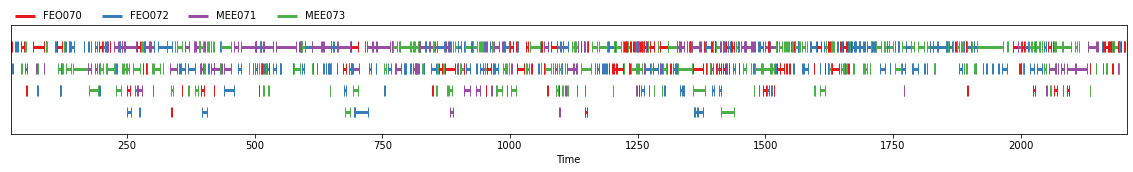

In [35]:
groundtruth # to see the labels of each speaker and time intervals, this will show last one only

In [ ]:
# print generated rttm of last test file
!cat {output_dir}/pred_rttms/TS3003d.Mix-Headset.rttm

pred_labels = rttm_to_labels(output_dir+'/pred_rttms/TS3003d.Mix-Headset.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

In [ ]:
# use spyder

hypothesis_rttm_list = []
hypothesis_rttm_filepath= os.path.join(output_dir, 'pred_rttms')

if test_type == 'test':
    hypothesis_rttm_list = glob.glob(hypothesis_rttm_filepath + '/*.rttm', recursive=True)
    
    for ground_rttm, hyp_rttm in zip(groundtruth_rttm_list, hypothesis_rttm_list):
        print("g h", ground_rttm)
        !spyder {ground_rttm} {hyp_rttm} --per-file

# der2 = abs(metric)

der = metric(groundtruth, hypothesis)
print(f'diarization error rate = {100 * der:.1f}%')